In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import families
from statsmodels.genmod import cov_struct
from statsmodels.genmod.families import links
import warnings
from adjustText import adjust_text

Full data

In [2]:
df = pd.read_json("results/task1/task1_data.json", lines=True)
#replace llama3.2 in the model column with llama3b
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
#replace llama3.2 in the model column with llama3b

#replace llama3.2 in the model column with llama3b
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')

df.drop(columns=['all_fit'], inplace=True)

df.rename(
    columns={
        'c_all_fit_hits': 'correct_match',
        'r_all_fit_hits': 'related_match',
        'r_all_fit_recall': 'related_recall'
    },
    inplace=True
)

df['related_recall'] = (df['related_recall'] * 10).astype(int)

code_path = "datasets/occupation.xlsx"
zone_path = "datasets/job_zone.xlsx"
# Read the Excel file
occupation = pd.read_excel(code_path)
occupation.drop(columns=['Description'], inplace=True)
occupation.columns = ['code', 'title']

zone = pd.read_excel(zone_path)
zone = zone[['Title', 'Job Zone']]
zone.columns = ['title', 'zone']

# Merge the occupation data with the main dataframe
df = df.merge(occupation, left_on='title', right_on='title', how='left')
df = df.merge(zone, left_on='title', right_on='title', how='left')
df["area"] = df["code"].apply(lambda x: x.split("-")[0])
df

,title,iteration,correct_match,related_match,related_recall,model,prompt,code,zone,area
0,Chief Executives,0,1,1,5,deepseek-r1,benchmark,11-1011.00,5,11
1,Chief Sustainability Officers,0,1,1,1,deepseek-r1,benchmark,11-1011.03,5,11
2,General and Operations Managers,0,0,0,0,deepseek-r1,benchmark,11-1021.00,4,11
3,Legislators,0,0,0,0,deepseek-r1,benchmark,11-1031.00,4,11
4,Advertising and Promotions Managers,0,0,1,9,deepseek-r1,benchmark,11-2011.00,4,11
...,...,...,...,...,...,...,...,...,...,...
73835,Gas Compressor and Gas Pumping Station Operators,9,0,1,2,mistral,persona,53-7071.00,2,53
73836,"Pump Operators, Except Wellhead Pumpers",9,0,0,0,mistral,persona,53-7072.00,2,53
73837,Wellhead Pumpers,9,0,0,0,mistral,persona,53-7073.00,2,53
73838,Refuse and Recyclable Material Collectors,9,0,0,0,mistral,persona,53-7081.00,2,53


In [3]:
# Ensure correct data types (especially for categorical grouping)
df['zone'] = df['zone'].astype(str)
df['area'] = df['area'].astype(str)
df['prompt'] = pd.Categorical(df['prompt'], categories=['benchmark', 'persona'], ordered=True)
df['model'] = df['model'].astype('category') # Ensure model is a category

# --- 2. Define Outcome Metrics ---
outcome_metrics = ['correct_match', 'related_match', 'related_recall']

# --- 3. Generate the Descriptive Statistics Table (Per Model, Per Prompt) ---
print("--- Descriptive Statistics by LLM Model and Prompt Type (Mean, Median, SD) ---")

# Group by 'model' and 'prompt' and aggregate
model_prompt_stats = df.groupby(['model', 'prompt'])[outcome_metrics].agg(['mean', 'median', 'std'])

# Unstack the 'prompt' level to make it the top-level column
# This gives the desired structure: Prompt -> Metric -> Stat
model_prompt_stats_unstacked = model_prompt_stats.unstack('prompt')

# Sort columns for consistent order: Benchmark first, then persona
# And within each, Metric -> Stat
model_prompt_stats_unstacked = model_prompt_stats_unstacked.sort_index(axis=1, level=[0, 1, 2])

# Print the DataFrame (rounded for better readability)
print(model_prompt_stats_unstacked.round(3))



--- Descriptive Statistics by LLM Model and Prompt Type (Mean, Median, SD) ---
            correct_match                                              \
                     mean            median               std           
prompt          benchmark persona benchmark persona benchmark persona   
model                                                                   
deepseek-r1         0.079   0.218       0.0     0.0     0.270   0.413   
llama3b             0.154   0.315       0.0     0.0     0.361   0.464   
llama70b            0.319   0.362       0.0     0.0     0.466   0.481   
mistral             0.112   0.228       0.0     0.0     0.315   0.419   

            related_match                                              \
                     mean            median               std           
prompt          benchmark persona benchmark persona benchmark persona   
model                                                                   
deepseek-r1         0.268   0.544       0.0 

C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\1179652835.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_prompt_stats = df.groupby(['model', 'prompt'])[outcome_metrics].agg(['mean', 'median', 'std'])


In [4]:
outcome_metrics = ['correct_match', 'related_match', 'related_recall']
for metric in outcome_metrics:
    bch = model_prompt_stats_unstacked[(metric, 'mean', 'benchmark')]
    per = model_prompt_stats_unstacked[(metric, 'mean', 'persona')]
    # Calculate the percentage difference
    percentage_difference = ((per - bch) / bch) * 100
    # add the percentage difference to the DataFrame
    model_prompt_stats_unstacked[(metric,'mean', '%difference')] = percentage_difference
model_prompt_stats_unstacked.round(3)['related_recall'].sort_values(by=('mean', '%difference'), ascending=False)

mean            median               std                mean
prompt      benchmark persona benchmark persona benchmark persona %difference
model                                                                        
deepseek-r1     0.650   1.771       0.0     1.0     1.412   2.205     172.231
llama3b         1.315   2.567       0.0     2.0     2.149   2.457      95.198
mistral         1.004   1.928       0.0     1.0     1.811   2.346      91.962
llama70b        2.561   2.918       2.0     3.0     2.478   2.553      13.962

In [5]:
df['correct_match'] = df['correct_match'].astype('int')  # Ensure model is a category
df['related_match'] = df['related_match'].astype('int')  # Ensure model is a category
df['related_recall'] = df['related_recall'].astype('float')  # Ensure model is a category

Averaged match rate

In [6]:
# Corrected aggregation syntax using a dictionary
df_avg = df.groupby(["title", "model", "prompt"]).agg({
	"correct_match": "mean",
	"related_match": "mean",
	"related_recall": "mean",
	"code": "first",
	"zone": "first",
	"area": "first"
}).reset_index()

df_avg

C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\1136043778.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg = df.groupby(["title", "model", "prompt"]).agg({


,title,model,prompt,correct_match,related_match,related_recall,code,zone,area
0,Accountants and Auditors,deepseek-r1,benchmark,0.0,0.0,0.0,13-2011.00,4,13
1,Accountants and Auditors,deepseek-r1,persona,0.0,1.0,5.9,13-2011.00,4,13
2,Accountants and Auditors,llama3b,benchmark,0.0,1.0,5.6,13-2011.00,4,13
3,Accountants and Auditors,llama3b,persona,0.0,1.0,6.0,13-2011.00,4,13
4,Accountants and Auditors,llama70b,benchmark,0.0,1.0,5.6,13-2011.00,4,13
...,...,...,...,...,...,...,...,...,...
7379,Zoologists and Wildlife Biologists,llama3b,persona,0.0,1.0,4.0,19-1023.00,4,19
7380,Zoologists and Wildlife Biologists,llama70b,benchmark,0.0,1.0,3.3,19-1023.00,4,19
7381,Zoologists and Wildlife Biologists,llama70b,persona,0.0,1.0,3.9,19-1023.00,4,19
7382,Zoologists and Wildlife Biologists,mistral,benchmark,0.0,0.0,0.0,19-1023.00,4,19


Correct Match Pivot

In [7]:
df_pivot = df.pivot_table(index=["title", "area", "zone", "model", "iteration"], columns=["prompt"], values="correct_match").reset_index()
df_pivot["difference"] = df_pivot["persona"] - df_pivot["benchmark"]
df_related_hit_pivot = df.pivot_table(index=["title", "area", "zone", "model", "iteration"], columns=["prompt"], values="related_match").reset_index()
df_related_hit_pivot["difference"] = df_related_hit_pivot["persona"] - df_related_hit_pivot["benchmark"]
df_recall_pivot = df.pivot_table(index=["title", "area", "zone", "model", "iteration"], columns=["prompt"], values="related_recall").reset_index()
df_recall_pivot["difference"] = df_recall_pivot["persona"] - df_recall_pivot["benchmark"]
df_pivot

C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\2491184102.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df.pivot_table(index=["title", "area", "zone", "model", "iteration"], columns=["prompt"], values="correct_match").reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\2491184102.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_related_hit_pivot = df.pivot_table(index=["title", "area", "zone", "model", "iteration"], columns=["prompt"], values="related_match").reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\2491184102.py:5: FutureWarning: The default value of observed=False is deprecated and will change to obser

prompt,title,area,zone,model,iteration,benchmark,persona,difference
0,Accountants and Auditors,13,4,deepseek-r1,0,0.0,0.0,0.0
1,Accountants and Auditors,13,4,deepseek-r1,1,0.0,0.0,0.0
2,Accountants and Auditors,13,4,deepseek-r1,2,0.0,0.0,0.0
3,Accountants and Auditors,13,4,deepseek-r1,3,0.0,0.0,0.0
4,Accountants and Auditors,13,4,deepseek-r1,4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
36915,Zoologists and Wildlife Biologists,19,4,mistral,5,0.0,0.0,0.0
36916,Zoologists and Wildlife Biologists,19,4,mistral,6,0.0,0.0,0.0
36917,Zoologists and Wildlife Biologists,19,4,mistral,7,0.0,0.0,0.0
36918,Zoologists and Wildlife Biologists,19,4,mistral,8,0.0,0.0,0.0


### Descriptive Stats

### Correct Match

C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\308072.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_avg['model'] = df_avg['model'].replace({'llama70b': 'Llama70b', 'llama3b': 'Llama3b', 'deepseek-r1': 'Deepseek-R1', 'mistral': 'Mistral'})


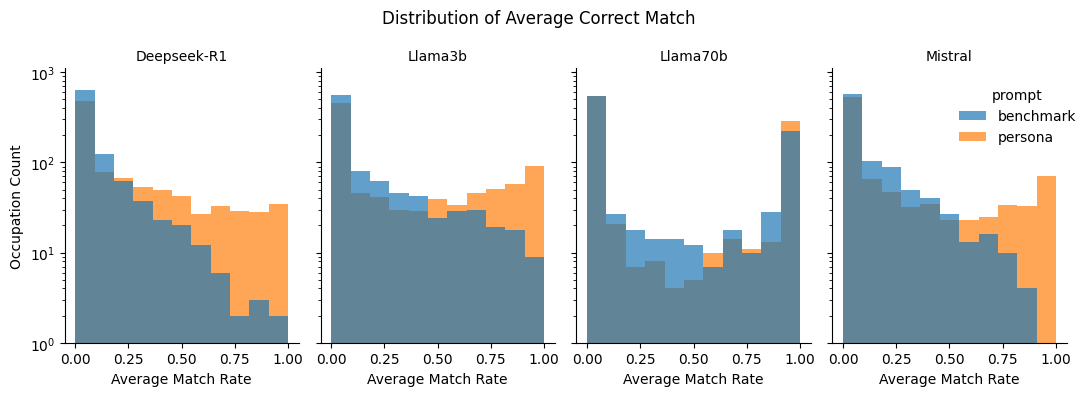

In [8]:
# Prepare data for displot
df_avg['model'] = df_avg['model'].replace({'llama70b': 'Llama70b', 'llama3b': 'Llama3b', 'deepseek-r1': 'Deepseek-R1', 'mistral': 'Mistral'})

g = sns.displot(
    data=df_avg,
    x="correct_match",
    hue="prompt",
    col="model",
    bins=11,
    kde=False,
    alpha=0.7,
    edgecolor=None,
    facet_kws={'sharey': True, 'sharex': True},
    height=4,      # height in inches (y-axis)
    aspect=0.6      # width = height * aspect (so 5*3 = 15 inches wide per facet)
)

# Set log scale and y-limits for all axes
max_y = max(df_avg[df_avg['model'] == model]['correct_match'].value_counts().max() for model in df_avg['model'].unique())
for ax in g.axes.flat:
    ax.set_yscale('log')
    ax.set_ylim(1, max_y)
    ax.set_xlabel("Average Match Rate")
    ax.set_ylabel("Occupation Count")

if g._legend is not None:
    g._legend.set_bbox_to_anchor((1, 0.8))
    g._legend.set_loc("upper right")

g.set_titles(col_template="{col_name}")
g.figure.suptitle("Distribution of Average Correct Match")
g.figure.tight_layout()

plt.show()

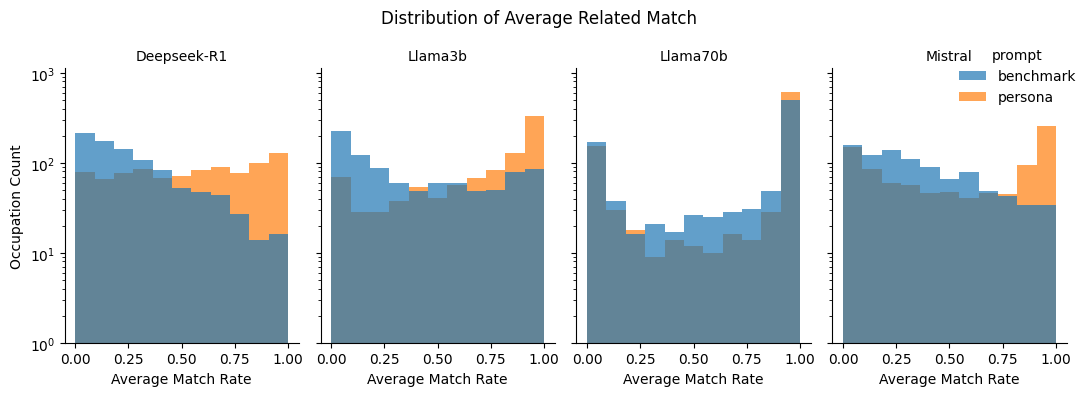

In [9]:
g = sns.displot(
    data=df_avg,
    x="related_match",
    hue="prompt",
    col="model",
    bins=11,
    kde=False,
    alpha=0.7,
    edgecolor=None,
    facet_kws={'sharey': True, 'sharex': True},
    height=4,      # height in inches (y-axis)
    aspect=0.6      # width = height * aspect (so 5*3 = 15 inches wide per facet)
)

# Set log scale and y-limits for all axes
max_y = max(df_avg[df_avg['model'] == model]['related_match'].value_counts().max() for model in df_avg['model'].unique())
for ax in g.axes.flat:
    ax.set_yscale('log')
    ax.set_ylim(1, max_y)
    ax.set_xlabel("Average Match Rate")
    ax.set_ylabel("Occupation Count")

if g._legend is not None:
    g._legend.set_bbox_to_anchor((1, 0.9))
    g._legend.set_loc("upper right")

g.set_titles(col_template="{col_name}")
g.figure.suptitle("Distribution of Average Related Match")
g.figure.tight_layout()

plt.show()

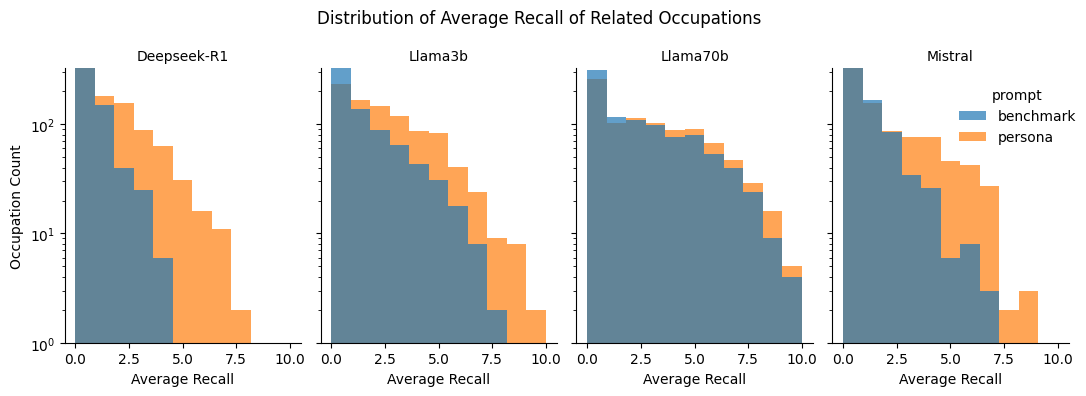

In [10]:
g = sns.displot(
    data=df_avg,
    x="related_recall",
    hue="prompt",
    col="model",
    bins=11,
    kde=False,
    alpha=0.7,
    edgecolor=None,
    facet_kws={'sharey': True, 'sharex': True},
    height=4,      # height in inches (y-axis)
    aspect=0.6      # width = height * aspect (so 5*3 = 15 inches wide per facet)
)

# Set log scale and y-limits for all axes
max_y = max(df_avg[df_avg['model'] == model]['related_recall'].value_counts().max() for model in df_avg['model'].unique())
for ax in g.axes.flat:
    ax.set_yscale('log')
    ax.set_ylim(1, max_y)
    ax.set_xlabel("Average Recall")
    ax.set_ylabel("Occupation Count")

if g._legend is not None:
    g._legend.set_bbox_to_anchor((1, 0.8))
    g._legend.set_loc("upper right")

g.set_titles(col_template="{col_name}")
g.figure.suptitle("Distribution of Average Recall of Related Occupations")
g.figure.tight_layout()

plt.show()

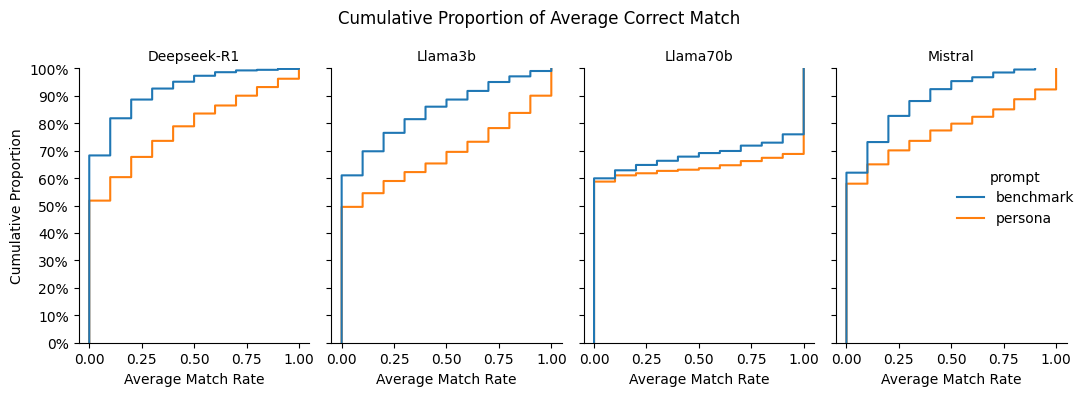

In [11]:
#add a figure size to the plot
g = sns.displot(
    data=df_avg,
    x="correct_match",
    hue="prompt",
    col="model",
    kind="ecdf",
    height=4,      # height in inches (y-axis)
    aspect=0.6
)
g.figure.suptitle("Cumulative Proportion of Average Correct Match")
g.set_axis_labels("Average Match Rate", "Cumulative Proportion")
g.set_titles(col_template="{col_name}")
#set y tick to percentage
g.set(yticks=np.arange(0, 1.1, 0.1), yticklabels=[f"{int(i*100)}%" for i in np.arange(0, 1.1, 0.1)])
g.figure.tight_layout()


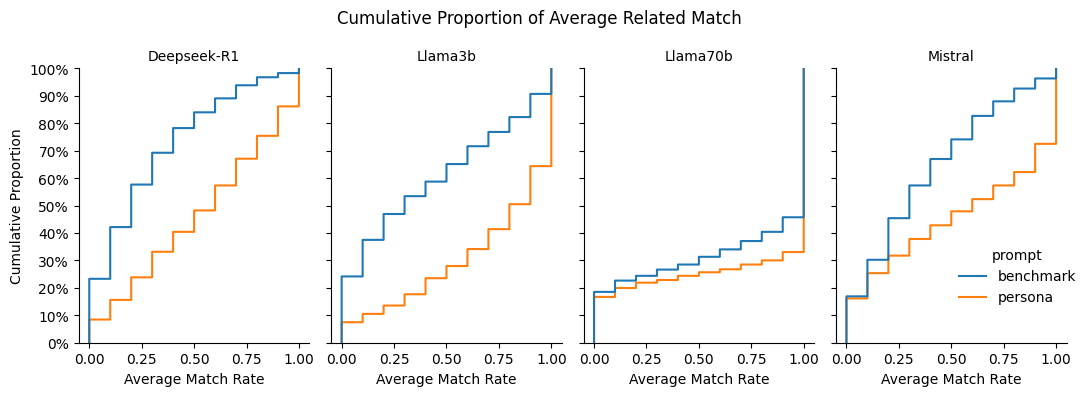

In [12]:
#add a figure size to the plot
g = sns.displot(
    data=df_avg,
    x="related_match",
    hue="prompt",
    col="model",
    kind="ecdf",
    height=4,      # height in inches (y-axis)
    aspect=0.6
)
g.figure.suptitle("Cumulative Proportion of Average Related Match")
g.set_axis_labels("Average Match Rate", "Cumulative Proportion")
g.set_titles(col_template="{col_name}")
if g._legend is not None:
    g._legend.set_bbox_to_anchor((1, 0.4))
    g._legend.set_loc("upper right")
#set y tick to percentage
g.set(yticks=np.arange(0, 1.1, 0.1), yticklabels=[f"{int(i*100)}%" for i in np.arange(0, 1.1, 0.1)])
g.figure.tight_layout()


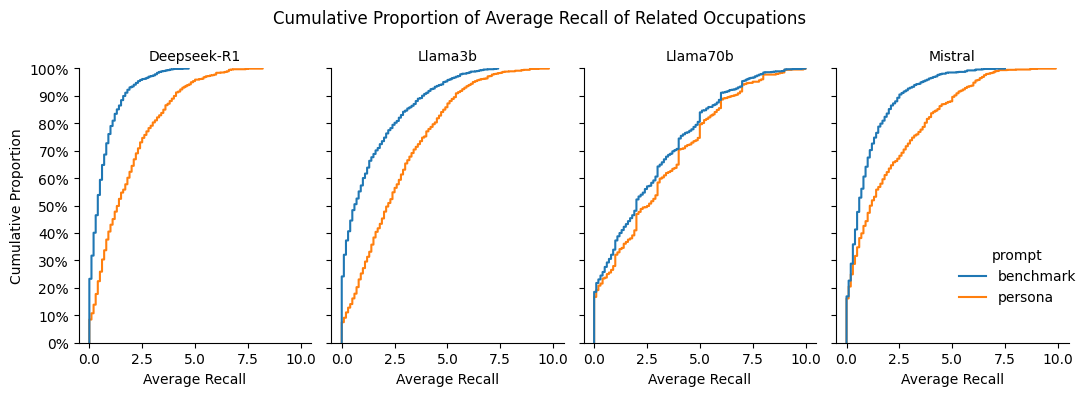

In [13]:
#add a figure size to the plot
g = sns.displot(
    data=df_avg,
    x="related_recall",
    hue="prompt",
    col="model",
    kind="ecdf",
    height=4,      # height in inches (y-axis)
    aspect=0.6
)
g.figure.suptitle("Cumulative Proportion of Average Recall of Related Occupations")
g.set_axis_labels("Average Recall", "Cumulative Proportion")
g.set_titles(col_template="{col_name}")
if g._legend is not None:
    g._legend.set_bbox_to_anchor((1, 0.4))
    g._legend.set_loc("upper right")
#set y tick to percentage
g.set(yticks=np.arange(0, 1.1, 0.1), yticklabels=[f"{int(i*100)}%" for i in np.arange(0, 1.1, 0.1)])
g.figure.tight_layout()


more occupations get a higher correct match rate using persona than benchmark. For llama70b, more occupations get a 100% correct match than benchmark.

looking at Average correct match = 0, at least half of the occupation do not get a match in all 10 rounds. However, persona prompt helped more occupation to get more matches.

C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\2485958061.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_area_new = df.groupby(["iteration","area", "model", "prompt"])["correct_match"].mean().reset_index()


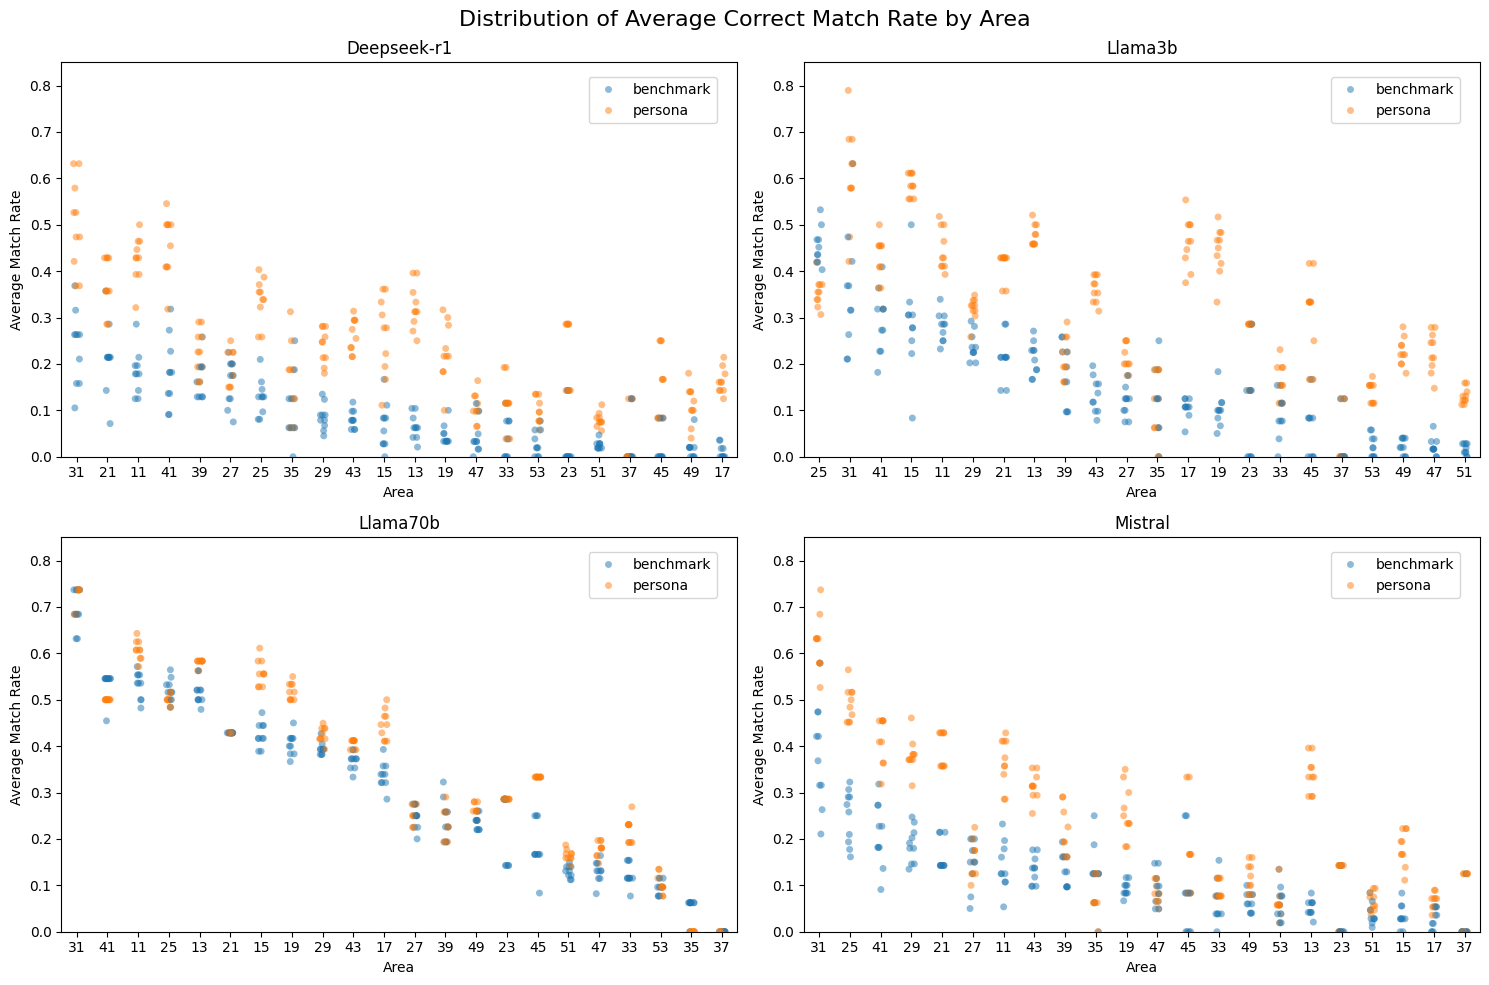

In [14]:
df_area_new = df.groupby(["iteration","area", "model", "prompt"])["correct_match"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(15, 10))
plt.suptitle("Distribution of Average Correct Match Rate by Area", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_area_new[df_area_new['model'] == model].copy()

    df_diff = df_model[df_model['prompt']=='benchmark'].groupby('area')[['correct_match']].mean()
    df_diff_sorted = df_diff.sort_values(by='correct_match', ascending=False).index
    sns.stripplot(data=df_model, x="area", y="correct_match", hue="prompt", dodge=False, 
              size=5, alpha=0.5, jitter=True, order=df_diff_sorted)
    plt.title(f'{model.capitalize()}')
    plt.xlabel('Area')
    plt.ylabel('Average Match Rate')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 0.85)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:], loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.tight_layout()
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\4230443803.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg_area = df_avg.groupby(["area", "model", "prompt"])["related_match"].mean().reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\4230443803.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_area_new = df.groupby(["iteration","area", "model", "prompt"])["related_match"].mean().reset_index()


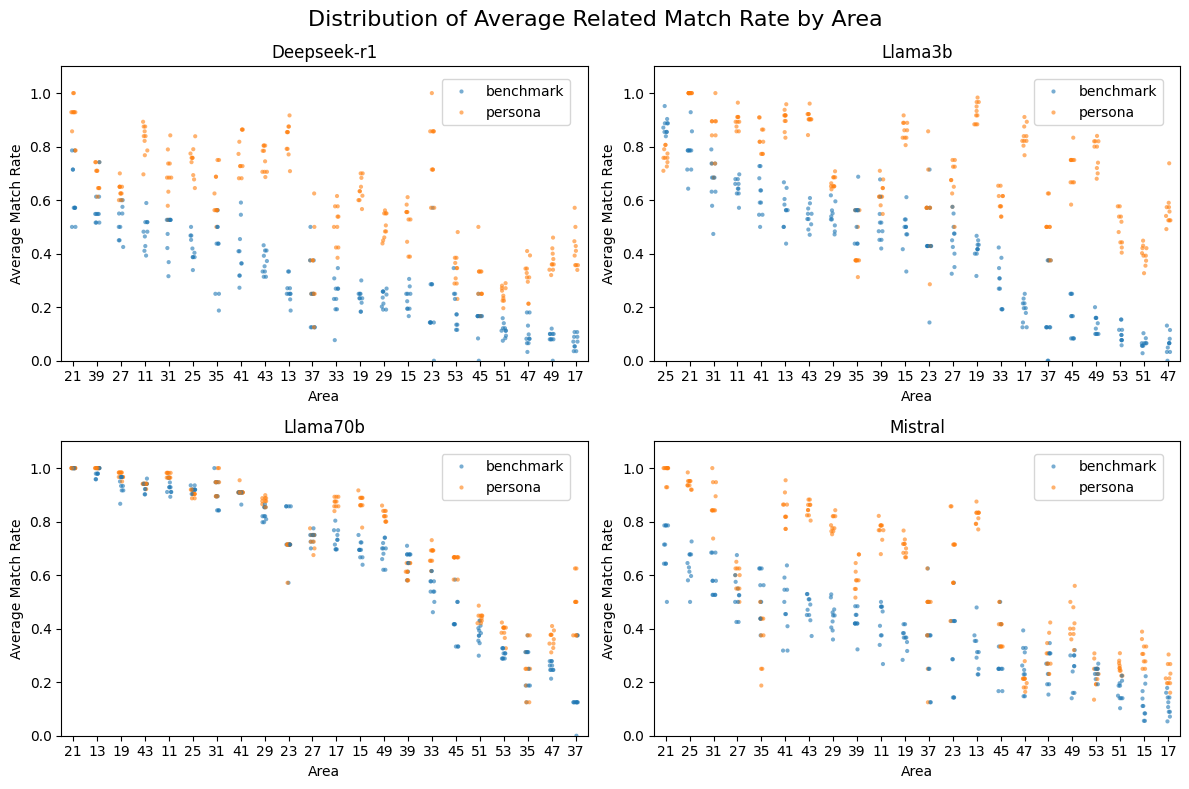

In [15]:
df_avg_area = df_avg.groupby(["area", "model", "prompt"])["related_match"].mean().reset_index()
df_area_new = df.groupby(["iteration","area", "model", "prompt"])["related_match"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(12, 8))
plt.suptitle("Distribution of Average Related Match Rate by Area", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_area_new[df_area_new['model'] == model].copy()

    df_diff = df_model[df_model['prompt'] == 'benchmark'].groupby('area')[['related_match']].mean()
    df_diff_sorted = df_diff.sort_values(by='related_match', ascending=False).index
    sns.stripplot(data=df_model, x="area", y="related_match", hue="prompt", dodge=False, 
              size=3, alpha=0.6, jitter=True, order=df_diff_sorted)
    plt.title(f'{model.capitalize()}')
    plt.xlabel('Area')
    plt.ylabel('Average Match Rate')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 1.1)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:], loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.tight_layout()
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\174875949.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_area_new = df.groupby(["iteration","area", "model", "prompt"])["related_recall"].mean().reset_index()


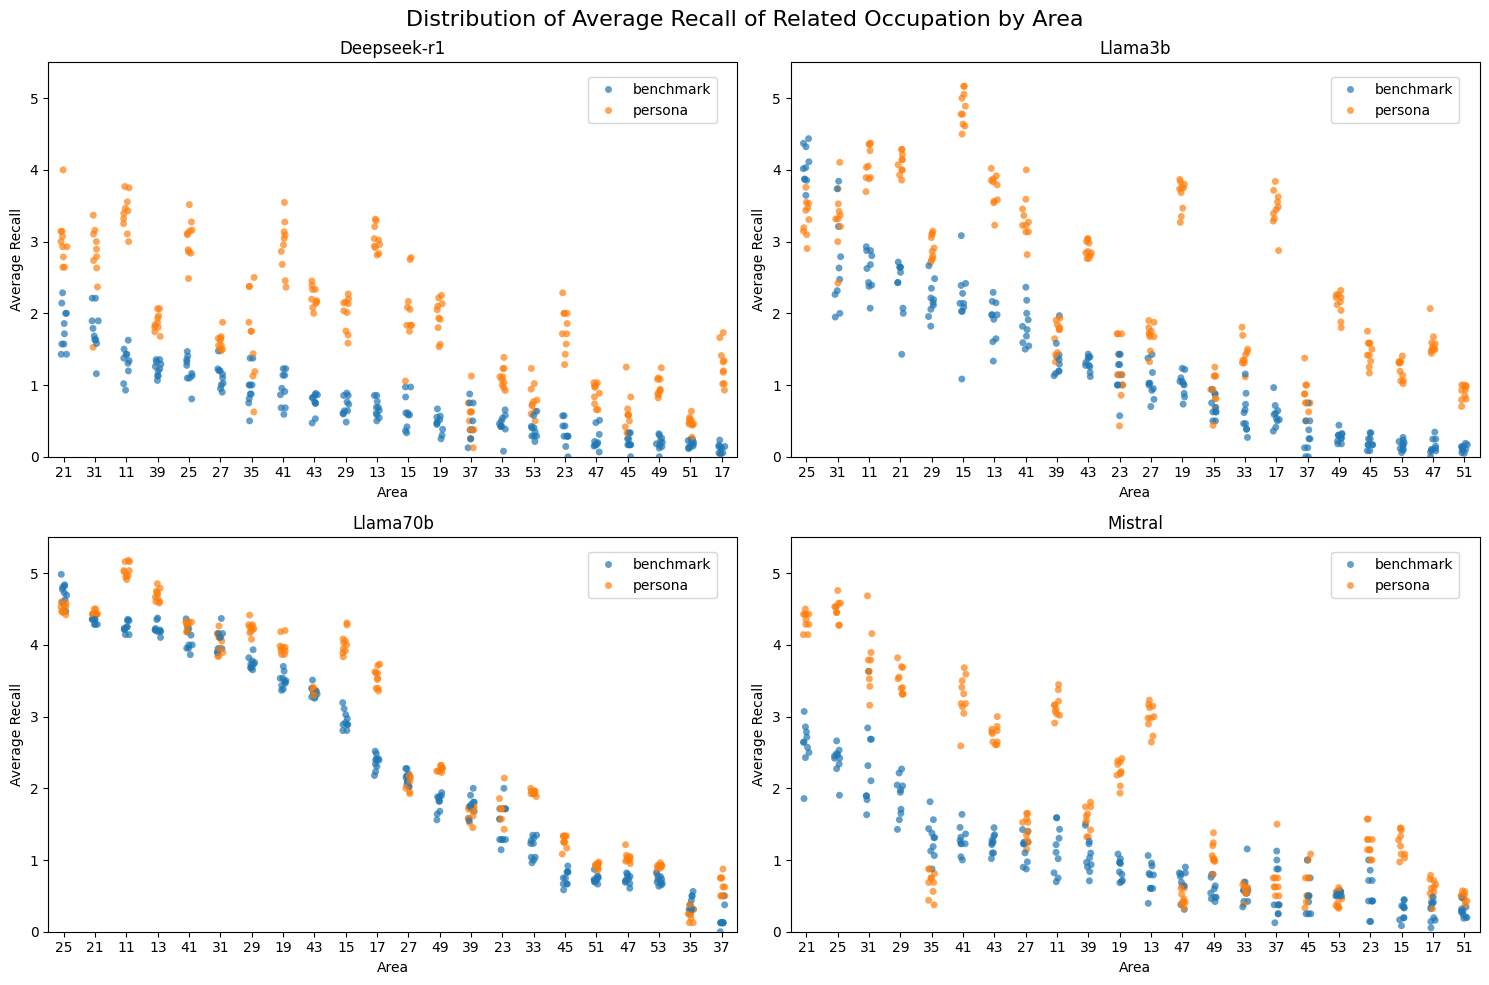

In [16]:
df_area_new = df.groupby(["iteration","area", "model", "prompt"])["related_recall"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(15, 10))
plt.suptitle("Distribution of Average Recall of Related Occupation by Area", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_area_new[df_area_new['model'] == model].copy()

    df_diff = df_model[df_model['prompt'] == 'benchmark'].groupby('area')[['related_recall']].mean()
    df_diff_sorted = df_diff.sort_values(by='related_recall', ascending=False).index
    sns.stripplot(data=df_model, x="area", y="related_recall", hue="prompt", dodge=False, 
              size=5, alpha=0.7, jitter=True, order=df_diff_sorted)
    plt.title(f'{model.capitalize()}')
    plt.xlabel('Area')
    plt.ylabel('Average Recall')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 5.5)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:], loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.tight_layout()
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\975272550.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  area_change = df.groupby(["iteration", "area", "model", "prompt"])[metric].mean().reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\975272550.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  area_change = area_change.pivot_table(index=["area", "model"], columns=["prompt"], values=metric).reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\975272550.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to re

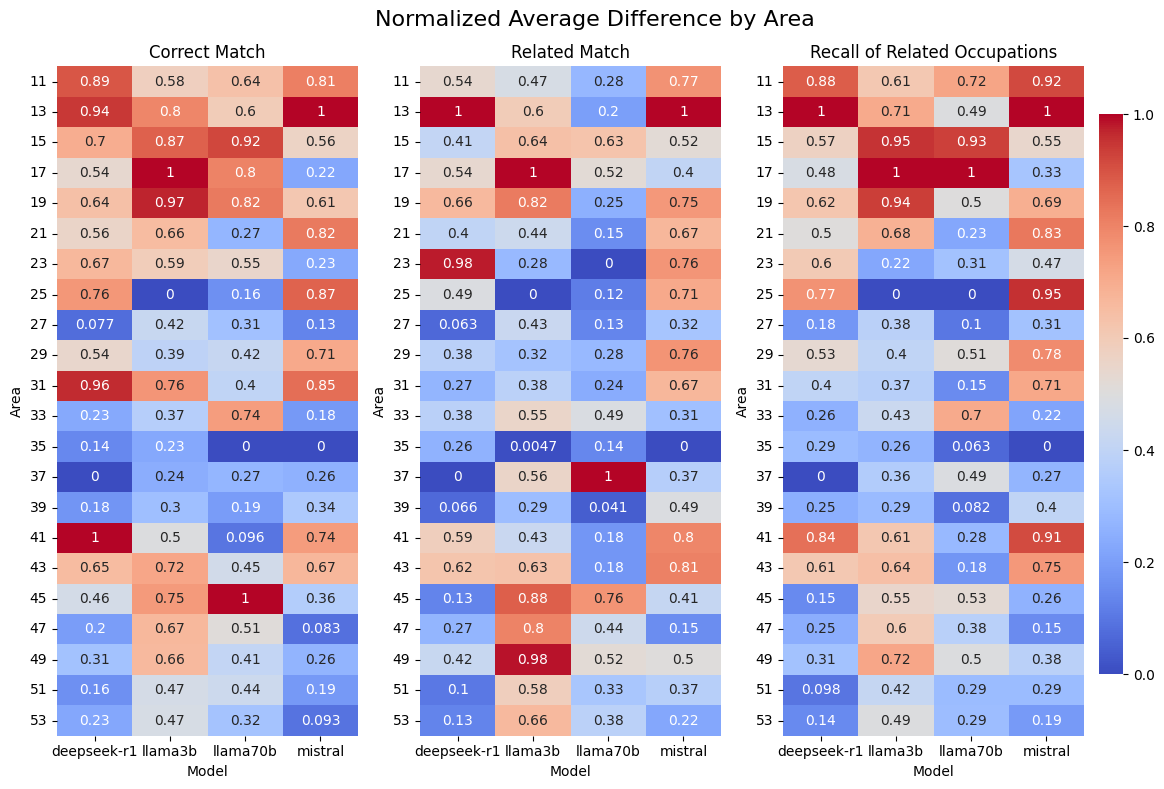

In [17]:
metrics = ['correct_match', 'related_match', 'related_recall']
titles = [
    "Correct Match",
    "Related Match",
    "Recall of Related Occupations"
]

fig, axes = plt.subplots(1, 3, figsize=(12, 8), sharex=True)

# Create a colorbar axis on the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

vmin, vmax = None, None  # Set to None for auto, or use fixed values for consistent color scaling

for i, (metric, title) in enumerate(zip(metrics, titles)):
    area_change = df.groupby(["iteration", "area", "model", "prompt"])[metric].mean().reset_index()
    area_change = area_change.pivot_table(index=["area", "model"], columns=["prompt"], values=metric).reset_index()
    area_change["difference"] = area_change["persona"] - area_change["benchmark"]
    area_change["normalized_difference"] = area_change.groupby("model")["difference"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0
    )
    heatmap_data = area_change.pivot(index="area", columns="model", values="normalized_difference")

    # For consistent color scaling across all plots, calculate vmin/vmax on first loop
    if vmin is None or vmax is None:
        vmin = heatmap_data.min().min()
        vmax = heatmap_data.max().max()

    sns.heatmap(
        heatmap_data,
        annot=True,
        cmap="coolwarm",
        ax=axes[i],
        cbar=(i == 0),  # Only add colorbar on the first plot, but we'll move it later
        cbar_ax=cbar_ax if i == 0 else None,
        vmin=vmin,
        vmax=vmax
    )
    axes[i].set_title(title)
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel("Area")
    axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0, ha='right')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0, ha='center')
plt.suptitle("Normalized Average Difference by Area", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.92, 1])  # Leave space for colorbar
plt.show()

C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\3825657098.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["correct_match"].mean().reset_index()


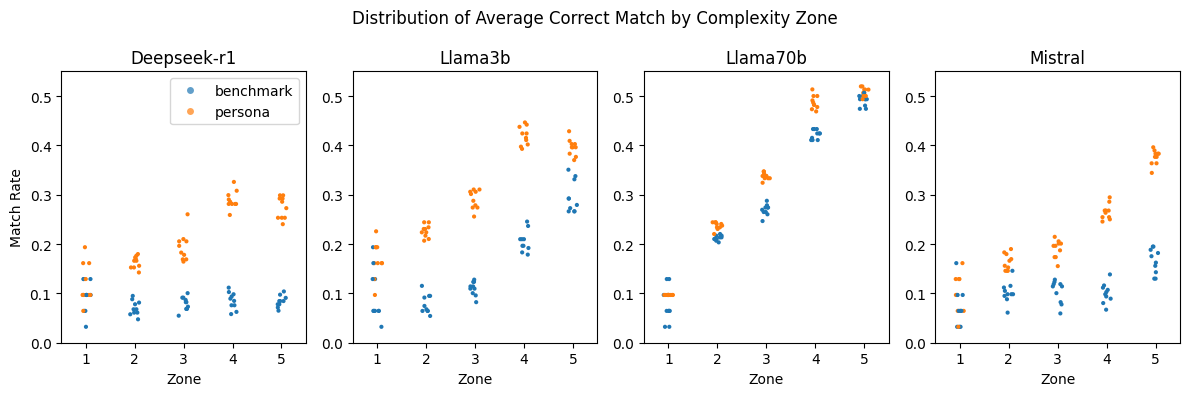

In [18]:
df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["correct_match"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(12, 4))
plt.suptitle("Distribution of Average Correct Match by Complexity Zone", fontsize=12)

for i, model in enumerate(models, 1):
    plt.subplot(1, 4, i)
    df_model = df_zone_new[df_zone_new['model'] == model].copy()

    df_diff = df_model.groupby('zone')[['correct_match']].mean()
    df_diff_sorted = df_diff.sort_values(by='correct_match', ascending=False).index
    sns.stripplot(data=df_model, x="zone", y="correct_match", hue="prompt", dodge=False, 
              size=3, alpha=1, jitter=True)
    plt.title(f'{model.capitalize()}')
    plt.xlabel('Zone')
    if i == 1:
        plt.ylabel('Match Rate')
        plt.legend(handles[:], labels[:])  # Only set y-label and legend on the first subplot
    else:
        plt.ylabel('')
        plt.legend([], [], frameon=False)  # Hide legend for other subplots
    plt.xticks()
    plt.ylim(0, 0.55)
    handles, labels = plt.gca().get_legend_handles_labels()

plt.tight_layout()
plt.show()




C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\676874315.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["related_match"].mean().reset_index()


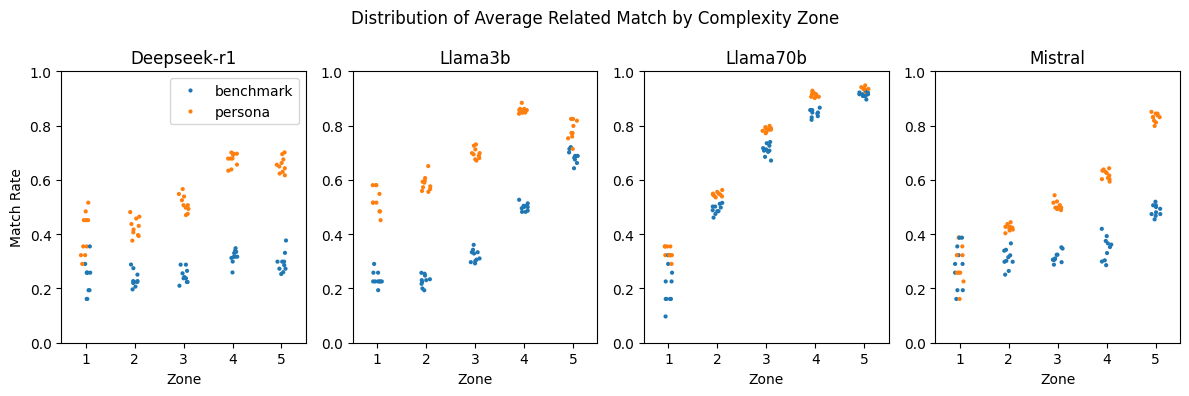

In [19]:
df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["related_match"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(12, 4))
plt.suptitle("Distribution of Average Related Match by Complexity Zone", fontsize=12)

for i, model in enumerate(models, 1):
    plt.subplot(1, 4, i)
    df_model = df_zone_new[df_zone_new['model'] == model].copy()

    df_diff = df_model.groupby('zone')[['related_match']].mean()
    df_diff_sorted = df_diff.sort_values(by='related_match', ascending=False).index
    sns.stripplot(data=df_model, x="zone", y="related_match", hue="prompt", dodge=False, 
              size=3, alpha=1, jitter=True)
    plt.title(f'{model.capitalize()}')
    plt.xlabel('Zone')
    if i == 1:
        plt.ylabel('Match Rate')
        plt.legend(handles[:], labels[:])  # Only set y-label and legend on the first subplot
    else:
        plt.ylabel('')
        plt.legend([], [], frameon=False)  # Hide legend for other subplots
    plt.xticks()
    plt.ylim(0, 1)
    handles, labels = plt.gca().get_legend_handles_labels()
    
plt.tight_layout()
plt.show()



C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\501613553.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["related_recall"].mean().reset_index()


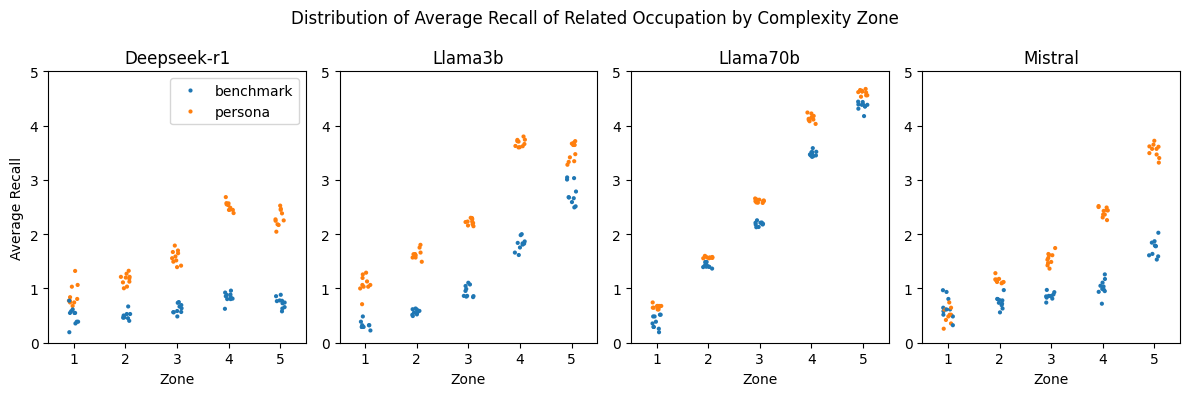

In [20]:
df_zone_new = df.groupby(["iteration","zone", "model", "prompt"])["related_recall"].mean().reset_index()

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(12, 4))
plt.suptitle("Distribution of Average Recall of Related Occupation by Complexity Zone", fontsize=12)

for i, model in enumerate(models, 1):
    plt.subplot(1, 4, i)
    df_model = df_zone_new[df_zone_new['model'] == model].copy()

    df_diff = df_model.groupby('zone')[['related_recall']].mean()
    df_diff_sorted = df_diff.sort_values(by='related_recall', ascending=False).index
    sns.stripplot(data=df_model, x="zone", y="related_recall", hue="prompt", dodge=False, 
              size=3, alpha=1, jitter=True)
    plt.title(f'{model.capitalize()}')
    plt.xlabel('Zone')
    if i == 1:
        plt.ylabel('Average Recall')
        plt.legend(handles[:], labels[:])  # Only set y-label and legend on the first subplot
    else:
        plt.ylabel('')
        plt.legend([], [], frameon=False)  # Hide legend for other subplots
    plt.xticks()
    plt.ylim(0, 5)
    handles, labels = plt.gca().get_legend_handles_labels()
    
plt.tight_layout()
plt.show()



C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\3178329946.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_change = df.groupby(["iteration","zone", "model", "prompt"])["correct_match"].mean().reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\3178329946.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  zone_change = zone_change.pivot_table(index=["zone", "model"], columns=["prompt"], values="correct_match").reset_index()
C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\3178329946.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

<Figure size 800x600 with 0 Axes>

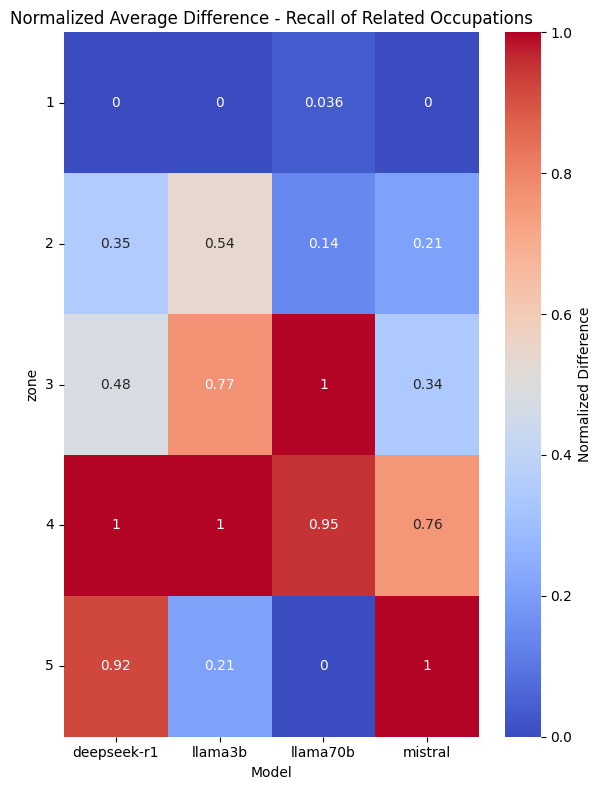

In [21]:
zone_change = df.groupby(["iteration","zone", "model", "prompt"])["correct_match"].mean().reset_index()
zone_change = zone_change.pivot_table(index=["zone", "model"], columns=["prompt"], values="correct_match").reset_index()
zone_change["difference"] = (zone_change["persona"] - zone_change["benchmark"])
zone_change["normalized_difference"] = zone_change.groupby("model")["difference"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0)

plt.figure(figsize=(8, 6))
# sns.barplot(data=zone_change, x="zone", y="normalized_difference", hue="model")
# Pivot the data so that rows are zone, columns are model, and values are normalized_difference
heatmap_data = zone_change.pivot(index="zone", columns="model", values="normalized_difference")

plt.figure(figsize=(6, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Normalized Difference'})
plt.title("Normalized Average Difference - Recall of Related Occupations")
plt.xlabel("Model")
plt.ylabel("zone")
plt.yticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

looking at the change in matching rate for eaach jobs, most jobs didnt get a boost (0 match rate). more jobs gets a boost of matching rate, although some jobs perform poorer using persona than benchmark.

In [22]:
#get a df to show the average correct match rate by model and prompt
avg_hits = df_avg.groupby(["model", "prompt"])["correct_match"].mean().reset_index()
avg_hits = avg_hits.pivot(index="model", columns="prompt", values="correct_match").reset_index()
avg_hits.columns.name = None  # Remove the name of the columns
avg_hits = avg_hits.rename(columns={"benchmark": "average_benchmark", "persona": "average_persona"})
avg_hits["difference"] = avg_hits["average_persona"] - avg_hits["average_benchmark"]
avg_hits["percentage_difference"] = (avg_hits["difference"] / avg_hits["average_benchmark"]) * 100
avg_hits = avg_hits.sort_values(by="percentage_difference", ascending=False)
avg_hits

C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\264900425.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_hits = df_avg.groupby(["model", "prompt"])["correct_match"].mean().reset_index()


,model,average_benchmark,average_persona,difference,percentage_difference
0,Deepseek-R1,0.079198,0.218310,0.139112,175.649795
1,Llama3b,0.153738,0.314735,0.160997,104.721635
3,Mistral,0.111593,0.227736,0.116143,104.077670
2,Llama70b,0.318635,0.362189,0.043554,13.668820


### final good GEE

In [23]:
# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)


# --- Data Loading and Initial Preprocessing ---
json_path = r'd:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\results\task1\task1_data.json'
code_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\occupation.xlsx"
zone_path = r"d:\OneDrive - Universität Mannheim\MMM\Master Thesis\Teapot\datasets\job_zone.xlsx"

try:
    df_gee = pd.read_json(json_path, lines=True)
except FileNotFoundError:
    print(f"Error: File {json_path} not found. Check path.")
    raise

# Filter for model and preprocess (using a sample LLM for demonstration)
# We will iterate through all LLMs to generate tables for each
all_llms = ["deepseek-r1", "llama3b", "llama70b", "mistral"] # Define all LLMs you want to process

# Prepare the DataFrame once for all LLMs (before filtering by single LLM)
df_gee['model'] = df_gee['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
df_gee['prompt'] = df_gee['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')
df_gee['prompt'] = df_gee['prompt'].astype('category')
df_gee.drop(columns=['all_fit'], inplace=True, errors='ignore')
df_gee.rename(columns={'c_all_fit_hits': 'correct_match', 'r_all_fit_hits': 'related_match', 'r_all_fit_recall': 'related_recall'}, inplace=True)

# Merge occupation and zone data
try:
    occupation = pd.read_excel(code_path)
    occupation.drop(columns=['Description'], inplace=True)
    occupation.columns = ['code', 'title']
    zone = pd.read_excel(zone_path)
    zone = zone[['Title', 'Job Zone']]
    zone.columns = ['title', 'zone']
except FileNotFoundError as e:
    print(f"Error: Excel file not found: {e}")
    raise

df_gee = df_gee.merge(occupation, on='title', how='left')
df_gee = df_gee.merge(zone, on='title', how='left')

df_gee['area'] = df_gee['code'].apply(lambda x: x.split('-')[0] if pd.notnull(x) else np.nan).fillna('Unknown')
df_gee['trials'] = 10

# Convert recall to integer count (multiplied by 10 as per your previous code)
df_gee['related_recall'] = (df_gee['related_recall'] *10).astype(int) 
df_gee['num_related_matches_failures'] = df_gee['trials'] - df_gee['related_recall']

# Ensure 'area' and 'zone' are categorical before reference selection
df_gee['area'] = df_gee['area'].astype('category')

unique_zones = df_gee['zone'].astype(str).dropna().unique().tolist()

# Define your desired order for zones, with '5' first
desired_zone_order = ['5'] + sorted([z for z in unique_zones if z != '5'])

df_gee['zone'] = pd.Categorical(df_gee['zone'].astype(str), categories=desired_zone_order, ordered=True) 
df_gee['zone'] = df_gee['zone'].astype(str).astype('category') # Ensure string then category


# Categorical type and order for 'prompt' and 'code'
df_gee['prompt'] = pd.Categorical(df_gee['prompt'], categories=['benchmark', 'persona'], ordered=False)
df_gee['code'] = pd.Categorical(df_gee['code'])
df_gee.sort_values(by=['prompt','code', 'area'],ascending=[True, True, False], inplace=True)

print("\nDataFrame head after critical preprocessing for GEE:")
print(df_gee[['model', 'prompt', 'zone', 'area', 'code', 'correct_match', 'related_match', 'related_recall', 'num_related_matches_failures']].head())
print(f"Number of unique code groups: {df_gee['code'].nunique()}")





# --- Helper Function for Running GEE Models and Extracting Odds Ratios ---
def calculate_gee_results_and_ors(dataframe, outcome_var, group_var, interaction_type, llm_name, reference_interaction_val):
    """
    Runs a GEE model, calculates persona vs. benchmark odds ratios with CIs,
    and returns a DataFrame suitable for plotting along with the full results object.
    """
    print(f"\n--- Running GEE Model for: {outcome_var} with prompt * {interaction_type} (Reference: {reference_interaction_val}) for LLM: {llm_name} ---")

    link_instance = links.Logit()
    results = None 

    if outcome_var == 'related_recall':
        endog_data = dataframe[['related_recall', 'num_related_matches_failures']].to_numpy()

        prompt_dummies = pd.get_dummies(dataframe['prompt'], prefix='prompt', drop_first=True)
        
        interaction_prefix = interaction_type + '_'
        interaction_dummies_all = pd.get_dummies(dataframe[interaction_type], prefix=interaction_type)
        reference_col_name = interaction_prefix + str(reference_interaction_val)
        
        interaction_dummies = interaction_dummies_all.drop(columns=[reference_col_name], errors='ignore')

        exog_base = pd.DataFrame({'Intercept': 1}, index=dataframe.index)
        exog_base = pd.concat([exog_base, prompt_dummies, interaction_dummies], axis=1)

        if 'prompt_persona' in prompt_dummies.columns:
            for col in interaction_dummies.columns:
                interaction_col_name = f"prompt_persona_x_{col}"
                exog_base[interaction_col_name] = prompt_dummies['prompt_persona'] * interaction_dummies[col]
        
        exog_df = exog_base.astype(float)

        model = sm.GEE(
            endog=endog_data,
            exog=exog_df,
            groups=dataframe[group_var],
            family=families.Binomial(link=link_instance),
            cov_struct=cov_struct.Exchangeable(),
            scale=None 
        )
        coef_map = {
            'persona_main': 'prompt_persona',
            'interaction_prefix': 'prompt_persona_x_',
            'interaction_type_prefix': interaction_prefix,
            'reference_interaction_prefix': interaction_prefix + str(reference_interaction_val)
        }
    else: 
        formula = f"{outcome_var} ~ C(prompt, Treatment(reference='benchmark')) * C({interaction_type}, Treatment(reference='{reference_interaction_val}'))"
        family_instance = families.Binomial(link=link_instance)
        
        model = smf.gee(
            formula=formula,
            data=dataframe,
            groups=dataframe[group_var],
            family=family_instance,
            cov_struct=cov_struct.Exchangeable(),
            scale=1.0 
        )
        coef_map = {
            'persona_main': 'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]',
            'interaction_prefix': f'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]:C({interaction_type}, Treatment(reference=\'{reference_interaction_val}\'))[T.',
            'interaction_type_prefix': '', 
            'reference_interaction_prefix': f'C({interaction_type}, Treatment(reference=\'{reference_interaction_val}\'))[T.'
        }
        
    try:
        results = model.fit()
        print(f"\n--- GEE Results Summary for {outcome_var} ~ prompt * {interaction_type} ---")
        print(results.summary())

        if outcome_var == 'related_recall':
            print(f"Estimated Dispersion (Scale) Parameter: {results.scale:.4f}")
            if results.scale > 1.2:
                print(f"--> Overdispersion detected (scale > 1.2) for {outcome_var}!")

        or_data = []
        categories = dataframe[interaction_type].cat.categories.tolist() if isinstance(dataframe[interaction_type].dtype, pd.CategoricalDtype) else sorted(dataframe[interaction_type].dropna().unique().tolist())
        # Ensure reference_interaction_val is correctly handled for plotting, putting it first
        if reference_interaction_val in categories:
            categories.remove(reference_interaction_val)
        categories = [reference_interaction_val] + categories

        persona_main_coef_name = coef_map['persona_main']
        persona_main_coef = results.params.get(persona_main_coef_name, 0)
        
        var_persona_main = results.cov_params().loc[persona_main_coef_name, persona_main_coef_name] if persona_main_coef_name in results.cov_params().index else 0

        for category in categories:
            if category == reference_interaction_val:
                combined_coef = persona_main_coef
                combined_vcov = var_persona_main
            else:
                if outcome_var == 'related_recall': # sm.GEE manual exog
                    interaction_coef_name = f"{coef_map['interaction_prefix']}{coef_map['interaction_type_prefix']}{category}"
                else: # smf.gee formula API
                    interaction_coef_name = f"{coef_map['interaction_prefix']}{category}]" 

                interaction_coef = results.params.get(interaction_coef_name, 0)
                combined_coef = persona_main_coef + interaction_coef
                
                var_interaction = results.cov_params().loc[interaction_coef_name, interaction_coef_name] if interaction_coef_name in results.cov_params().columns else 0
                cov_main_interaction = results.cov_params().loc[persona_main_coef_name, interaction_coef_name] if (persona_main_coef_name in results.cov_params().index and interaction_coef_name in results.cov_params().columns) else 0
                
                combined_vcov = var_persona_main + var_interaction + 2 * cov_main_interaction
                
            std_err = np.sqrt(combined_vcov)
            
            or_value = np.exp(combined_coef)
            or_ci_lower = np.exp(combined_coef - 1.96 * std_err)
            or_ci_upper = np.exp(combined_coef + 1.96 * std_err)

            or_data.append({
                interaction_type: category,
                'metric': outcome_var,
                'llm': llm_name,
                'odds_ratio': or_value,
                'ci_lower': or_ci_lower,
                'ci_upper': or_ci_upper
            })

        return pd.DataFrame(or_data), results, coef_map

    except Exception as e:
        print(f"Error fitting model for {outcome_var} (prompt * {interaction_type}): {e}")
        return pd.DataFrame(), None, None


# --- NEW FUNCTION: Calculate Predicted Probabilities ---
# Added llm_name as a direct parameter
def calculate_predicted_probabilities(results_object, interaction_type, reference_interaction_val, outcome_var, coef_map, llm_name):
    """
    Calculates predicted probabilities for 'benchmark' and 'persona' prompts
    across all levels of the specified interaction variable.
    """
    predicted_probs_data = []
    
    # Base coefficients
    intercept_coef = results_object.params.get('Intercept', 0)
    
    # Coefficient for 'persona' prompt (main effect)
    persona_main_coef_name = coef_map['persona_main']
    persona_main_coef = results_object.params.get(persona_main_coef_name, 0)

    # Extract unique categories from the coefficients themselves (excluding 'Intercept' and main prompt effect)
    all_interaction_categories = set()
    for param_name in results_object.params.index:
        if param_name.startswith(f"C({interaction_type},") and "Treatment" in param_name: # smf.gee
            start = param_name.find('[T.') + 3
            end = param_name.find(']', start)
            if start != -1 and end != -1:
                all_interaction_categories.add(param_name[start:end])
        elif param_name.startswith(f"{interaction_type}_") and not param_name.startswith("prompt_persona_x_"): # sm.GEE
             all_interaction_categories.add(param_name.replace(f"{interaction_type}_", ""))

    # Add the reference category to the set
    all_interaction_categories.add(str(reference_interaction_val)) # Ensure reference is string

    # Sort categories for consistent plotting order, putting reference first
    categories_for_plotting = sorted(list(all_interaction_categories))
    if str(reference_interaction_val) in categories_for_plotting: # Ensure reference is in string format for comparison
        categories_for_plotting.remove(str(reference_interaction_val))
    categories_for_plotting.insert(0, str(reference_interaction_val)) # Place reference at the beginning

    for category in categories_for_plotting:
        # 1. Predict for 'benchmark' prompt
        log_odds_benchmark = intercept_coef
        
        # Add main effect of interaction category (if not reference)
        if category != str(reference_interaction_val):
            interaction_category_coef_name = ""
            if outcome_var == 'related_recall': # sm.GEE style
                interaction_category_coef_name = f"{interaction_type}_{category}"
            else: # smf.gee style
                interaction_category_coef_name = f"C({interaction_type}, Treatment(reference='{reference_interaction_val}'))[T.{category}]"
            
            log_odds_benchmark += results_object.params.get(interaction_category_coef_name, 0)

        prob_benchmark = 1 / (1 + np.exp(-log_odds_benchmark))

        # 2. Predict for 'persona' prompt
        log_odds_persona = intercept_coef + persona_main_coef

        # Add main effect of interaction category (if not reference)
        if category != str(reference_interaction_val):
            # This coefficient is already added in benchmark_log_odds calculation
            log_odds_persona += results_object.params.get(interaction_category_coef_name, 0)
            
            # Add interaction term
            interaction_term_coef_name = ""
            if outcome_var == 'related_recall': # sm.GEE style
                interaction_term_coef_name = f"{coef_map['interaction_prefix']}{coef_map['interaction_type_prefix']}{category}"
            else: # smf.gee style
                interaction_term_coef_name = f"{coef_map['interaction_prefix']}{category}]"

            log_odds_persona += results_object.params.get(interaction_term_coef_name, 0)

        prob_persona = 1 / (1 + np.exp(-log_odds_persona))

        predicted_probs_data.append({
            'llm': llm_name, # Use the passed llm_name
            'outcome': outcome_var,
            'prompt': 'benchmark',
            interaction_type: category,
            'predicted_probability': prob_benchmark
        })
        predicted_probs_data.append({
            'llm': llm_name, # Use the passed llm_name
            'outcome': outcome_var,
            'prompt': 'persona',
            interaction_type: category,
            'predicted_probability': prob_persona
        })

    return pd.DataFrame(predicted_probs_data)

# --- Function to format GEE results for LaTeX table ---
def format_gee_results_for_latex(results_object, model_name="Model", decimal_places=3, interaction_type_str=""):
    """
    Extracts and formats key regression results for LaTeX output.

    Args:
        results_object: The fitted statsmodels GEE results object.
        model_name (str): A name for the model (e.g., 'Correct Match Model').
        decimal_places (int): Number of decimal places for numerical values.
        interaction_type_str (str): 'area' or 'zone' to help with parameter naming.

    Returns:
        pandas.DataFrame: A DataFrame suitable for direct conversion to LaTeX.
    """
    
    params = results_object.params
    bse = results_object.bse
    zvalues = results_object.tvalues # For GEE, statsmodels calls it tvalues, but it's z-stat
    pvalues = results_object.pvalues
    conf_int = results_object.conf_int()

    data = []

    for param_name in params.index:
        estimate = params[param_name]
        std_err = bse[param_name]
        z_val = zvalues[param_name]
        p_val = pvalues[param_name]
        ci_lower = conf_int.loc[param_name, 0]
        ci_upper = conf_int.loc[param_name, 1]

        p_str = f"{p_val:.{decimal_places}f}"
        if p_val < 0.001:
            p_str = "$<$0.001***"
        elif p_val < 0.01:
            p_str += "**"
        elif p_val < 0.05:
            p_str += "*"
        
        # Clean up parameter names for presentation
        display_param_name = param_name

        # Handle 'Intercept'
        if display_param_name == 'Intercept':
            display_param_name = 'Intercept'
        # Handle main prompt effect
        elif 'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]' in display_param_name:
            display_param_name = 'Persona'
        # Handle main interaction type effects
        elif 'C(' + interaction_type_str + ',' in display_param_name and ':C(prompt' not in display_param_name:
             # Extract the category, e.g., 'Area 19' from 'C(area, Treatment(...))[T.19]'
            start = display_param_name.find('[T.') + 3
            end = display_param_name.find(']', start)
            category = display_param_name[start:end]
            display_param_name = f'{interaction_type_str.capitalize()} {category}'
        # Handle interaction terms
        elif 'C(prompt, Treatment(reference=\'benchmark\'))[T.persona]:C(' in display_param_name:
            # Extract the interaction type category, e.g., 'Area 19'
            parts = display_param_name.split(':C(')
            interaction_part = parts[1] # e.g., 'area, Treatment(reference='19-0000'))[T.11-0000]'
            start = interaction_part.find('[T.') + 3
            end = interaction_part.find(']', start)
            category = interaction_part[start:end]
            display_param_name = f'Persona $\\times$ {interaction_type_str.capitalize()} {category}'
        
        # Handle specific cases for related_recall when using sm.GEE (manual exog)
        elif display_param_name == 'prompt_persona':
            display_param_name = 'Persona'
        elif display_param_name.startswith(f'{interaction_type_str}_'):
            category = display_param_name.replace(f'{interaction_type_str}_', '')
            display_param_name = f'{interaction_type_str.capitalize()} {category}'
        elif display_param_name.startswith('prompt_persona_x_'):
            category = display_param_name.replace('prompt_persona_x_', '')
            category = category.replace(f'{interaction_type_str}_', '') # Remove interaction type prefix from category itself
            display_param_name = f'Persona $\\times$ {interaction_type_str.capitalize()} {category}'
            
        data.append({
            'Parameter': display_param_name,
            'Estimate': round(estimate, decimal_places),
            'Std. Error': round(std_err, decimal_places),
            'Z-value': round(z_val, decimal_places),
            'P-value': p_str,
            '95% CI Lower': round(ci_lower, decimal_places),
            '95% CI Upper': round(ci_upper, decimal_places)
        })

    results_df = pd.DataFrame(data)
    return results_df

# --- Main GEE Execution Loop ---
all_or_results = []
all_gee_results = [] # Stores fitted results and other info for LaTeX tables
all_predicted_probabilities = [] # New list to store predicted probabilities

for llm_name in all_llms:
    current_llm_df = df_gee[df_gee['model'] == llm_name].copy()
    
    if current_llm_df.empty:
        print(f"Skipping LLM {llm_name}: No data available.")
        continue

    print(f"\n--- Processing LLM: {llm_name} ---")

    for outcome in ['correct_match', 'related_match', 'related_recall']:
        
        # Diagnose perfect separation for the current LLM and outcome (good practice)
        # This part of the diagnosis was in your original code, kept here for context.
        # It's specifically for 'related_recall' in your original code.
        # If perfect separation happens for other outcomes, smf.gee will often handle it by dropping terms or giving warnings.
        if outcome == 'related_recall':
            print(f"\n--- Diagnosing Perfect Separation for {outcome} ({llm_name}) ---")
            for p in current_llm_df['prompt'].unique():
                for i in current_llm_df['area'].unique():
                    subset = current_llm_df[(current_llm_df['prompt'] == p) & (current_llm_df['area'] == i)]
                    if not subset.empty and (subset['related_recall'].min() == 0 and subset['related_recall'].max() == 0):
                        print(f"Warning: Perfect separation (all 0s) for prompt='{p}', area='{i}' (n={len(subset)})")
                    if not subset.empty and (subset['related_recall'].min() == 10 and subset['related_recall'].max() == 10):
                        print(f"Warning: Perfect separation (all 10s) for prompt='{p}', area='{i}' (n={len(subset)})")
                for z in current_llm_df['zone'].unique():
                    subset = current_llm_df[(current_llm_df['prompt'] == p) & (current_llm_df['zone'] == z)]
                    if not subset.empty and (subset['related_recall'].min() == 0 and subset['related_recall'].max() == 0):
                        print(f"Warning: Perfect separation (all 0s) for prompt='{p}', zone='{z}' (n={len(subset)})")
                    if not subset.empty and (subset['related_recall'].min() == 10 and subset['related_recall'].max() == 10):
                        print(f"Warning: Perfect separation (all 10s) for prompt='{p}', zone='{z}' (n={len(subset)})")
            print("--- End Diagnosis ---")


        # Determine reference categories for the current LLM and outcome
        current_reference_area = '11'
        current_reference_zone = '5'

        # Area interaction
        area_or_df, area_results, area_coef_map = calculate_gee_results_and_ors(current_llm_df, outcome, 'code', 'area', llm_name, current_reference_area)
        if not area_or_df.empty:
            all_or_results.append(area_or_df)
        if area_results:
            all_gee_results.append({'llm': llm_name, 'outcome': outcome, 'interaction': 'area', 'results': area_results})
            # NEW: Calculate and store predicted probabilities
            predicted_probs_area = calculate_predicted_probabilities(area_results, 'area', current_reference_area, outcome, area_coef_map, llm_name)
            if not predicted_probs_area.empty:
                all_predicted_probabilities.append(predicted_probs_area)

        # Zone interaction
        zone_or_df, zone_results, zone_coef_map = calculate_gee_results_and_ors(current_llm_df, outcome, 'code', 'zone', llm_name, current_reference_zone)
        if not zone_or_df.empty:
            all_or_results.append(zone_or_df)
        if zone_results:
            all_gee_results.append({'llm': llm_name, 'outcome': outcome, 'interaction': 'zone', 'results': zone_results})
            # NEW: Calculate and store predicted probabilities
            predicted_probs_zone = calculate_predicted_probabilities(zone_results, 'zone', current_reference_zone, outcome, zone_coef_map, llm_name)
            if not predicted_probs_zone.empty:
                all_predicted_probabilities.append(predicted_probs_zone)

if all_or_results:
    final_or_df = pd.concat(all_or_results)
    print("\n--- Consolidated Odds Ratios for Plotting (Sample) ---")
    print(final_or_df.head())
else:
    print("No odds ratio data generated. Check for errors during GEE model fitting.")
    final_or_df = pd.DataFrame()


# NEW: Consolidate all predicted probabilities
if all_predicted_probabilities:
    final_predicted_probs_df = pd.concat(all_predicted_probabilities)
    print("\n--- Consolidated Predicted Probabilities (Sample) ---")
    print(final_predicted_probs_df.head())
else:
    print("No predicted probabilities generated. Check for errors during GEE model fitting.")
    final_predicted_probs_df = pd.DataFrame()


DataFrame head after critical preprocessing for GEE:
           model     prompt zone area        code  correct_match  \
0    deepseek-r1  benchmark    5   11  11-1011.00              1   
100  deepseek-r1  benchmark    5   11  11-1011.00              0   
200  deepseek-r1  benchmark    5   11  11-1011.00              1   
300  deepseek-r1  benchmark    5   11  11-1011.00              0   
400  deepseek-r1  benchmark    5   11  11-1011.00              1   

     related_match  related_recall  num_related_matches_failures  
0                1               5                             5  
100              0               0                            10  
200              1               1                             9  
300              0               0                            10  
400              1               1                             9  
Number of unique code groups: 923

--- Processing LLM: deepseek-r1 ---

--- Running GEE Model for: correct_match with prompt * area (Re

C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\151821806.py:180: RuntimeWarning: invalid value encountered in sqrt
  std_err = np.sqrt(combined_vcov)



--- GEE Results Summary for correct_match ~ prompt * zone ---
                               GEE Regression Results                              
Dep. Variable:               correct_match   No. Observations:                18460
Model:                                 GEE   No. clusters:                      923
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  20
Family:                           Binomial   Mean cluster size:                20.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Tue, 10 Jun 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         13:57:37
                                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------

C:\Users\godfr\AppData\Local\Temp\ipykernel_28248\151821806.py:180: RuntimeWarning: invalid value encountered in sqrt
  std_err = np.sqrt(combined_vcov)



--- GEE Results Summary for related_match ~ prompt * zone ---
                               GEE Regression Results                              
Dep. Variable:               related_match   No. Observations:                18460
Model:                                 GEE   No. clusters:                      923
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  20
Family:                           Binomial   Mean cluster size:                20.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Tue, 10 Jun 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         13:57:39
                                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------

In [24]:
xx="""C(prompt, Treatment(reference='benchmark'))[T.persona]:C(area, Treatment(reference='11'))[T.13]""".split(':C(')[1]

interaction_part = xx
start = interaction_part.find('[T.') + 3
end = interaction_part.find(']', start)
category = interaction_part[start:end]
display_param_name = f'Persona $\\times$ {interaction_part.split(',')[0].capitalize()} {category}'
display_param_name

'Persona $\\times$ Area 13'


--- Plotting Odds Ratios by Area for all LLMs ---


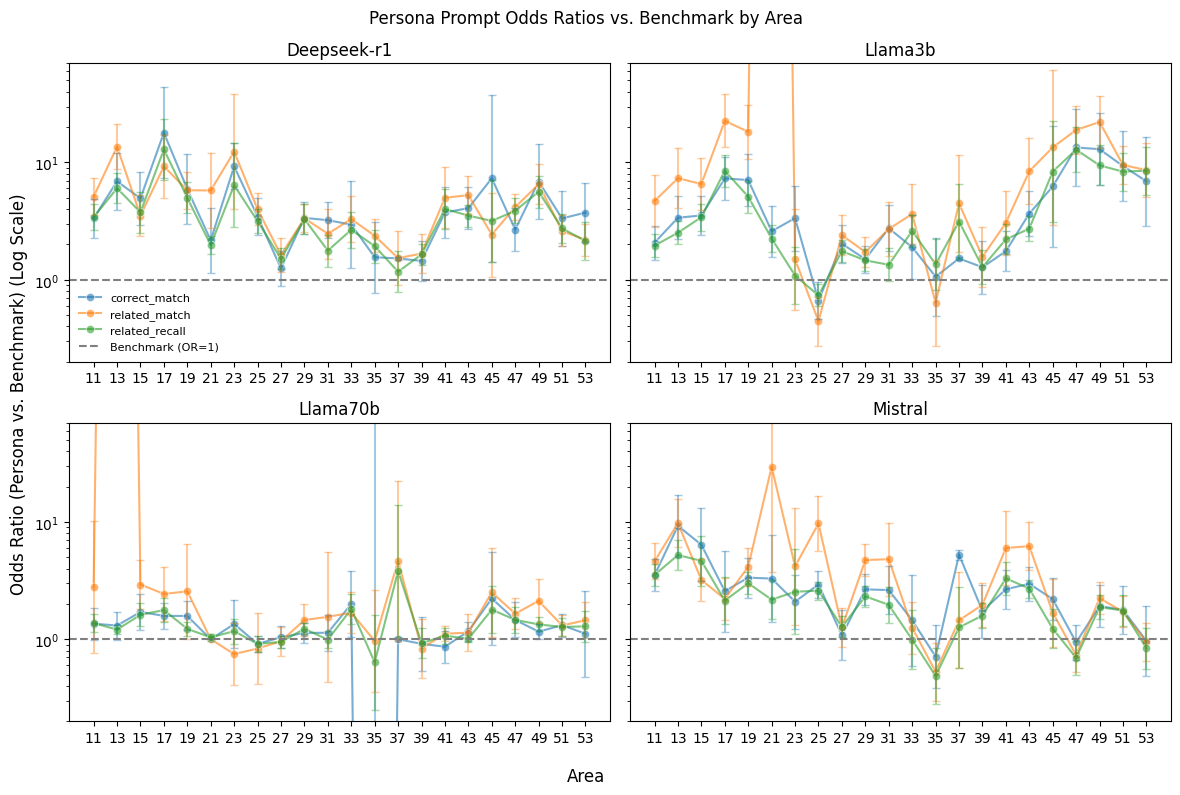


--- Plotting Odds Ratios by Zone for all LLMs ---


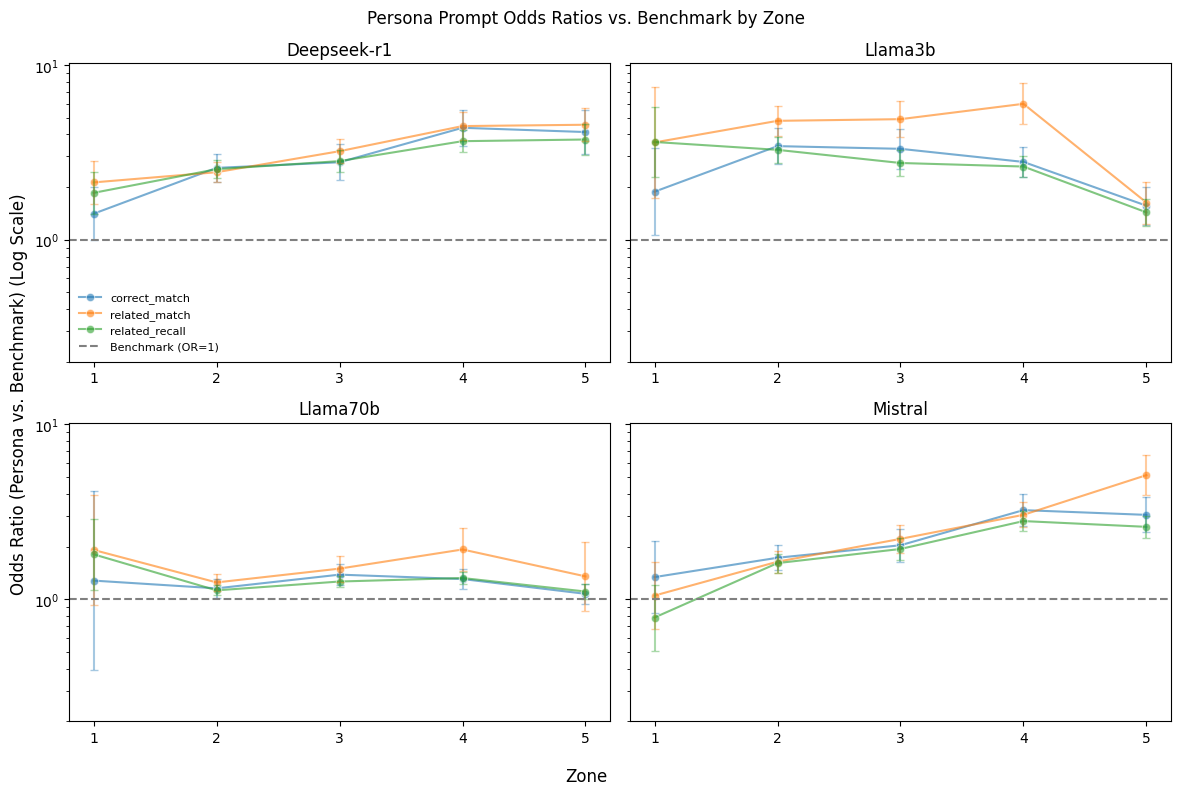


Finished plotting all Odds Ratios.


In [25]:
# Assume 'final_or_df' DataFrame is already loaded and contains your combined OR results.
# And 'llms' list is defined:
llms = ["deepseek-r1", "llama3b", "llama70b", "mistral"]
final_or_df['odds_ratio'] = final_or_df['odds_ratio'].astype(float)


all_area_categories = sorted(final_or_df['area'].dropna().unique().tolist())
all_zone_categories = sorted(final_or_df['zone'].dropna().unique().tolist())


# --- Plotting the Odds Ratios in Subplots ---
for interaction_type in ['area', 'zone']:
    print(f"\n--- Plotting Odds Ratios by {interaction_type.capitalize()} for all LLMs ---")
    
    # Create the figure and subplots (2x2 for 4 LLMs)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharey=True)
    axes = axes.flatten() # Flatten the 2x2 array of axes for easy indexing

    # Determine consistent X-axis order for this interaction_type
    if interaction_type == 'area':
        ordered_categories_for_plot = all_area_categories
    else: # interaction_type == 'zone'
        ordered_categories_for_plot = all_zone_categories

    # Calculate global Y-axis limits for consistent comparison across subplots
    # Filter for the specific interaction_type across all LLMs and metrics
    global_plot_data = final_or_df[final_or_df[interaction_type].notna()]
    if not global_plot_data.empty:
        global_min_or = global_plot_data['ci_lower'].min()
        global_max_or = global_plot_data['ci_upper'].max()
        
        # Adjust limits for plotting, ensuring not too close to 0 for log scale
        # Add some padding: 0.7 for lower bound, 1.3 for upper bound
        y_min_plot = max(global_min_or * 0.5, 0.2) # Ensure it's not below 0 and not too close to 0 for log scale
        y_max_plot = min(global_max_or * 1.3, 70) # Cap at 70 for better visibility

        # Set the y-axis limits on the first subplot, which will apply to all due to sharey=True
        axes[0].set_ylim(y_min_plot, y_max_plot)
    else:
        print(f"No data for {interaction_type} to set global y-limits. Skipping plot.")
        plt.close(fig) # Close the empty figure
        continue # Skip to next interaction_type if no data

    for i, llm in enumerate(llms): # Iterate through LLMs to populate each subplot
        ax = axes[i] # Get the current subplot axis

        # Filter the final_or_df DataFrame for the current llm and interaction type
        plot_df = final_or_df[(final_or_df['llm'] == llm) & (final_or_df[interaction_type].notna())].copy()

        if plot_df.empty:
            ax.set_title(f'LLM: {llm} (No Data)')
            ax.set_xticks([]) # Remove ticks if no data
            ax.set_yticks([])
            continue

        # Apply the determined order for plotting to plot_df's interaction_type column
        plot_df[interaction_type] = pd.Categorical(plot_df[interaction_type], 
                                                   categories=ordered_categories_for_plot, 
                                                   ordered=True)
        plot_df.sort_values(by=[interaction_type, 'metric'], inplace=True)

        sns.lineplot(
            data=plot_df,
            x=interaction_type,
            y='odds_ratio',
            hue='metric',
            errorbar=None, # We'll plot CIs manually
            marker='o',
            alpha=0.6, # Slightly increased alpha for better visibility
            ax=ax # IMPORTANT: specify the subplot axis
        )

        # Plot confidence intervals manually
        metrics_for_plotting = plot_df['metric'].unique().tolist()
        for j, metric in enumerate(metrics_for_plotting):
            subset = plot_df[plot_df['metric'] == metric].sort_values(by=interaction_type)
            
            # Ensure proper alignment for error bars, convert categorical positions to numerical
            x_positions = [plot_df[interaction_type].cat.categories.get_loc(str(cat)) for cat in subset[interaction_type]]

            lower_err = subset['odds_ratio'] - subset['ci_lower']
            upper_err = subset['ci_upper'] - subset['odds_ratio']
            
            # Clamp error bar values to prevent negative lengths on log scale if ci_lower is 0 or very small
            # (though the log scale handles this by pushing it to -infinity if truly 0)
            # For visualization, it's important that ci_lower != 0 to avoid log(0) issues, handled by y_min_plot = max(..., 0.05)
            # np.maximum(lower_err, 0) is also good if ci_lower could theoretically be larger than odds_ratio due to floating point.
            lower_err = np.maximum(subset['odds_ratio'] - subset['ci_lower'], 0)
            upper_err = np.maximum(subset['ci_upper'] - subset['odds_ratio'], 0)
            ax.errorbar( # IMPORTANT: specify the subplot axis
                x=x_positions,
                y=subset['odds_ratio'],
                yerr=[lower_err, upper_err],
                fmt='none',
                capsize=3,
                alpha=0.4,
                color=sns.color_palette()[j] # Match line color using index
            )
            
        # Add text labels for x-axis ticks
        ax.set_xticks(ticks=range(len(ordered_categories_for_plot)))
        ax.set_xticklabels(labels=ordered_categories_for_plot, ha='center')
            
        ax.axhline(1, color='gray', linestyle='--', linewidth=1.5, label='Benchmark (OR=1)')
        ax.set_yscale('log') # Set log scale for each subplot

        ax.set_title(f'{llm.capitalize()}') # Title for individual subplot
        ax.set_xlabel('') # Clear individual x-labels for common supxlabel
        ax.set_ylabel('') # Clear individual y-labels for common supylabel
        if i == 0:
            ax.legend(title='', loc='lower left', fontsize='8', frameon=False) # Show legend only on the first subplot
        else:
            ax.legend_.remove() if ax.legend_ else None # Hide legend on other subplots
        ax.tick_params(axis='x', labelbottom=True) # Ensure x-labels are visible

    # Set overall figure title and labels
    fig.suptitle(f'Persona Prompt Odds Ratios vs. Benchmark by {interaction_type.capitalize()}') # Adjust y to move title up
    fig.supxlabel(interaction_type.capitalize(), fontsize=12) 
    fig.supylabel('Odds Ratio (Persona vs. Benchmark) (Log Scale)', fontsize=12) 
    
    plt.tight_layout() # Adjust layout to make space for suptitle/supx/supy
    plt.show()

print("\nFinished plotting all Odds Ratios.")

In [26]:
# Ensure final_predicted_probs_df is available from your previous code execution
# It should contain 'llm', 'outcome', 'prompt', 'area' (or 'zone'), 'predicted_probability'

# --- Data Preparation for Plotting ---
# We need to reshape the data so that 'benchmark_prob' and 'persona_prob' are separate columns
# This requires separating the data based on whether it's an 'area' or 'zone' interaction.

# Filter for 'area' interactions (where 'area' column has values)
predicted_probs_area_only = final_predicted_probs_df[final_predicted_probs_df['area'].notna()].copy()
# Pivot to get benchmark and persona probabilities side-by-side
pivot_area_df = predicted_probs_area_only.pivot_table(
    index=['llm', 'outcome', 'area'], # Group by LLM, outcome, and area category
    columns='prompt',                  # Pivot the 'prompt' column
    values='predicted_probability'     # Use 'predicted_probability' as values
).reset_index()
# Rename columns for clarity and remove the 'prompt' column name
pivot_area_df.rename(columns={'benchmark': 'benchmark_prob', 'persona': 'persona_prob'}, inplace=True)
pivot_area_df.columns.name = None # Clean up columns index name

# Filter for 'zone' interactions (where 'zone' column has values)
predicted_probs_zone_only = final_predicted_probs_df[final_predicted_probs_df['zone'].notna()].copy()
# Pivot for Zone
pivot_zone_df = predicted_probs_zone_only.pivot_table(
    index=['llm', 'outcome', 'zone'], # Group by LLM, outcome, and zone category
    columns='prompt',                  # Pivot the 'prompt' column
    values='predicted_probability'     # Use 'predicted_probability' as values
).reset_index()
# Rename columns and remove the 'prompt' column name
pivot_zone_df.rename(columns={'benchmark': 'benchmark_prob', 'persona': 'persona_prob'}, inplace=True)
pivot_zone_df.columns.name = None # Clean up columns index name


# Define the list of LLMs and outcomes to iterate through for plotting
all_llms = ["deepseek-r1", "llama3b", "llama70b", "mistral"]
all_outcomes_to_plot = ['correct_match', 'related_match', 'related_recall']


# Filter for 'area' interactions (where 'area' column has values)
predicted_probs_area_only = final_predicted_probs_df[final_predicted_probs_df['area'].notna()].copy()
pivot_area_df = predicted_probs_area_only.pivot_table(
    index=['llm', 'outcome', 'area'], 
    columns='prompt',                  
    values='predicted_probability'     
).reset_index()
pivot_area_df.rename(columns={'benchmark': 'benchmark_prob', 'persona': 'persona_prob'}, inplace=True)
pivot_area_df.columns.name = None 

# Filter for 'zone' interactions (where 'zone' column has values)
predicted_probs_zone_only = final_predicted_probs_df[final_predicted_probs_df['zone'].notna()].copy()
pivot_zone_df = predicted_probs_zone_only.pivot_table(
    index=['llm', 'outcome', 'zone'], 
    columns='prompt',                  
    values='predicted_probability'     
).reset_index()
pivot_zone_df.rename(columns={'benchmark': 'benchmark_prob', 'persona': 'persona_prob'}, inplace=True)
pivot_zone_df.columns.name = None 

# Define the list of LLMs and outcomes to iterate through for plotting
all_llms = ["deepseek-r1", "llama3b", "llama70b", "mistral"]
all_outcomes_to_plot = ['correct_match', 'related_match', 'related_recall']


# Filter for 'area' interactions (where 'area' column has values)
predicted_probs_area_only = final_predicted_probs_df[final_predicted_probs_df['area'].notna()].copy()
pivot_area_df = predicted_probs_area_only.pivot_table(
    index=['llm', 'outcome', 'area'], 
    columns='prompt',                  
    values='predicted_probability'     
).reset_index()
pivot_area_df.rename(columns={'benchmark': 'benchmark_prob', 'persona': 'persona_prob'}, inplace=True)
pivot_area_df.columns.name = None 

# Filter for 'zone' interactions (where 'zone' column has values)
predicted_probs_zone_only = final_predicted_probs_df[final_predicted_probs_df['zone'].notna()].copy()
pivot_zone_df = predicted_probs_zone_only.pivot_table(
    index=['llm', 'outcome', 'zone'], 
    columns='prompt',                  
    values='predicted_probability'     
).reset_index()
pivot_zone_df.rename(columns={'benchmark': 'benchmark_prob', 'persona': 'persona_prob'}, inplace=True)
pivot_zone_df.columns.name = None 

# Define the list of LLMs and outcomes to iterate through for plotting
all_llms = ["deepseek-r1", "llama3b", "llama70b", "mistral"]
all_outcomes_to_plot = ['correct_match', 'related_match', 'related_recall']
final_predicted_probs_df



,llm,outcome,prompt,area,predicted_probability,zone
0,deepseek-r1,correct_match,benchmark,11,0.182143,NaN
1,deepseek-r1,correct_match,persona,11,0.426786,NaN
2,deepseek-r1,correct_match,benchmark,13,0.064583,NaN
3,deepseek-r1,correct_match,persona,13,0.322917,NaN
4,deepseek-r1,correct_match,benchmark,15,0.066667,NaN
...,...,...,...,...,...,...
5,mistral,related_recall,persona,NaN,0.115051,2
6,mistral,related_recall,benchmark,NaN,0.086164,3
7,mistral,related_recall,persona,NaN,0.154429,3
8,mistral,related_recall,benchmark,NaN,0.101964,4


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


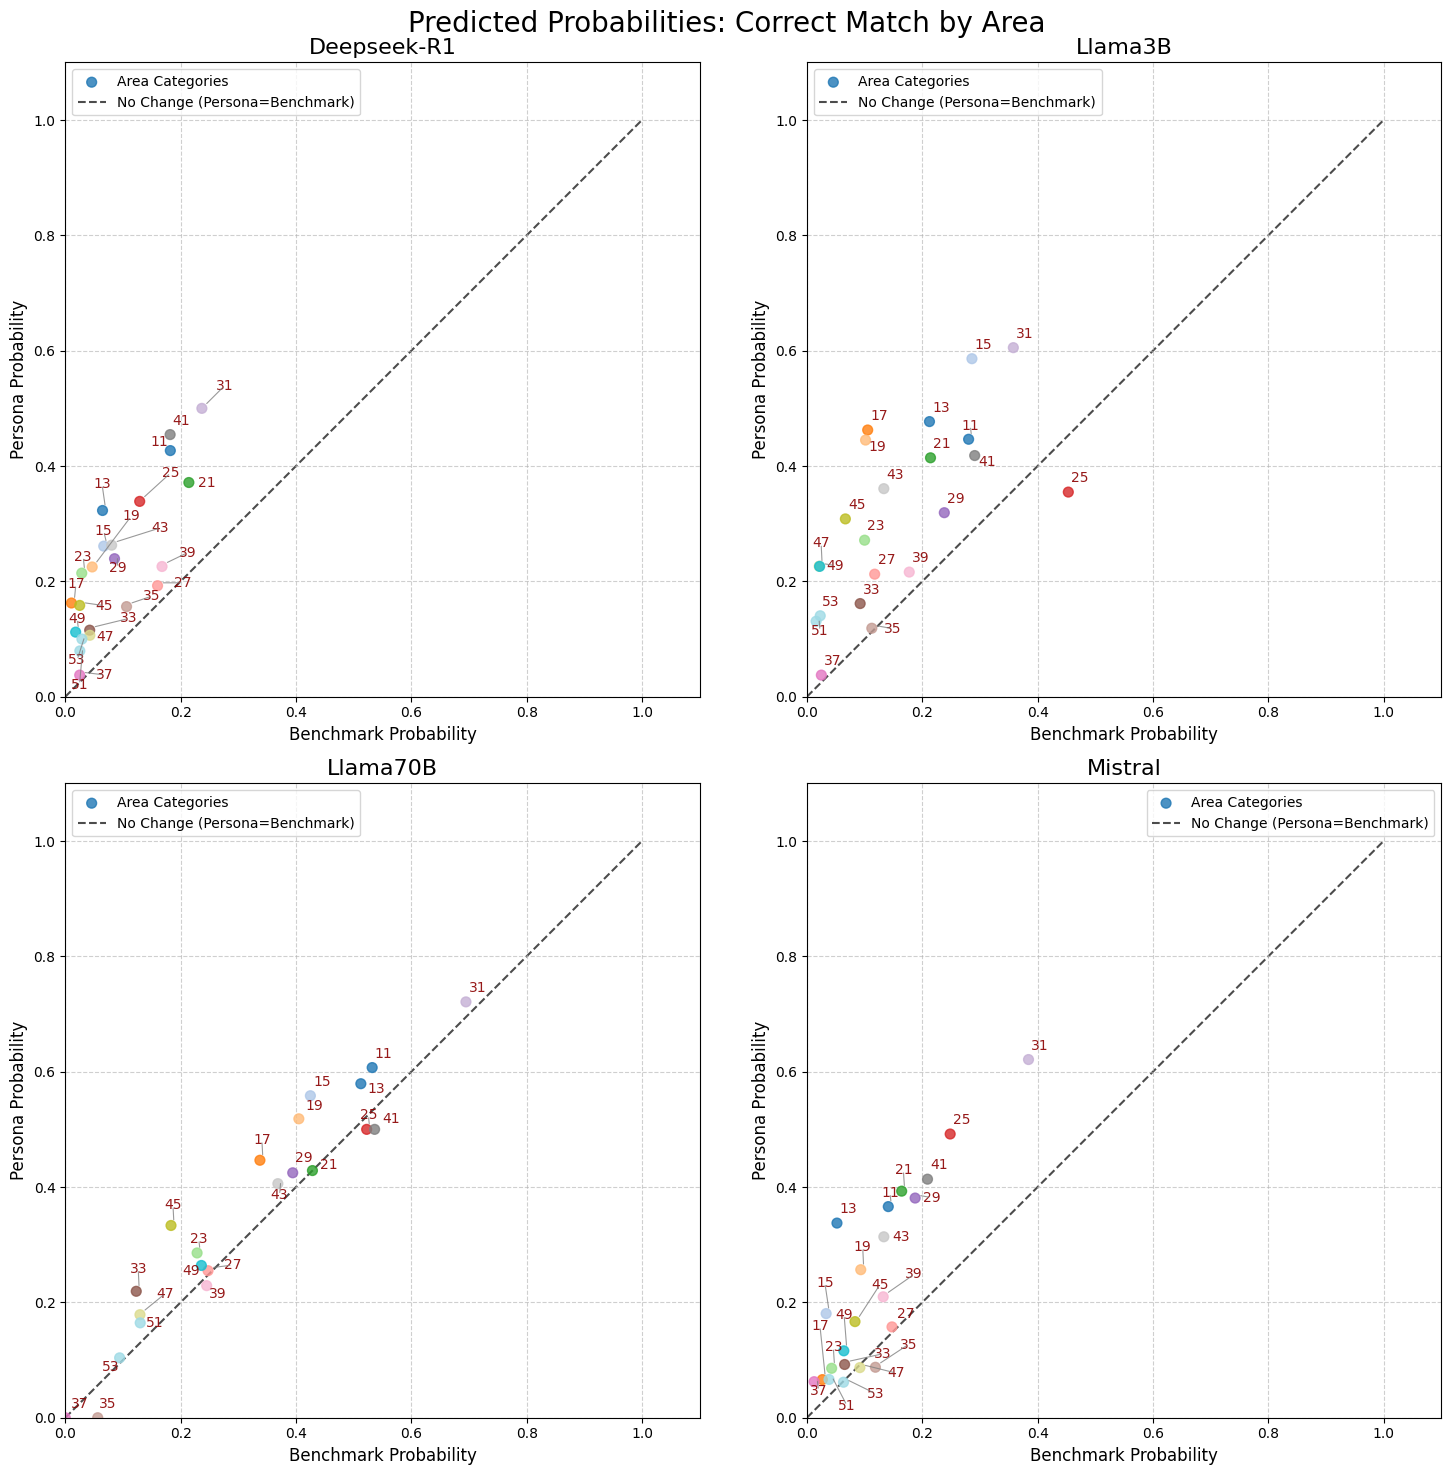

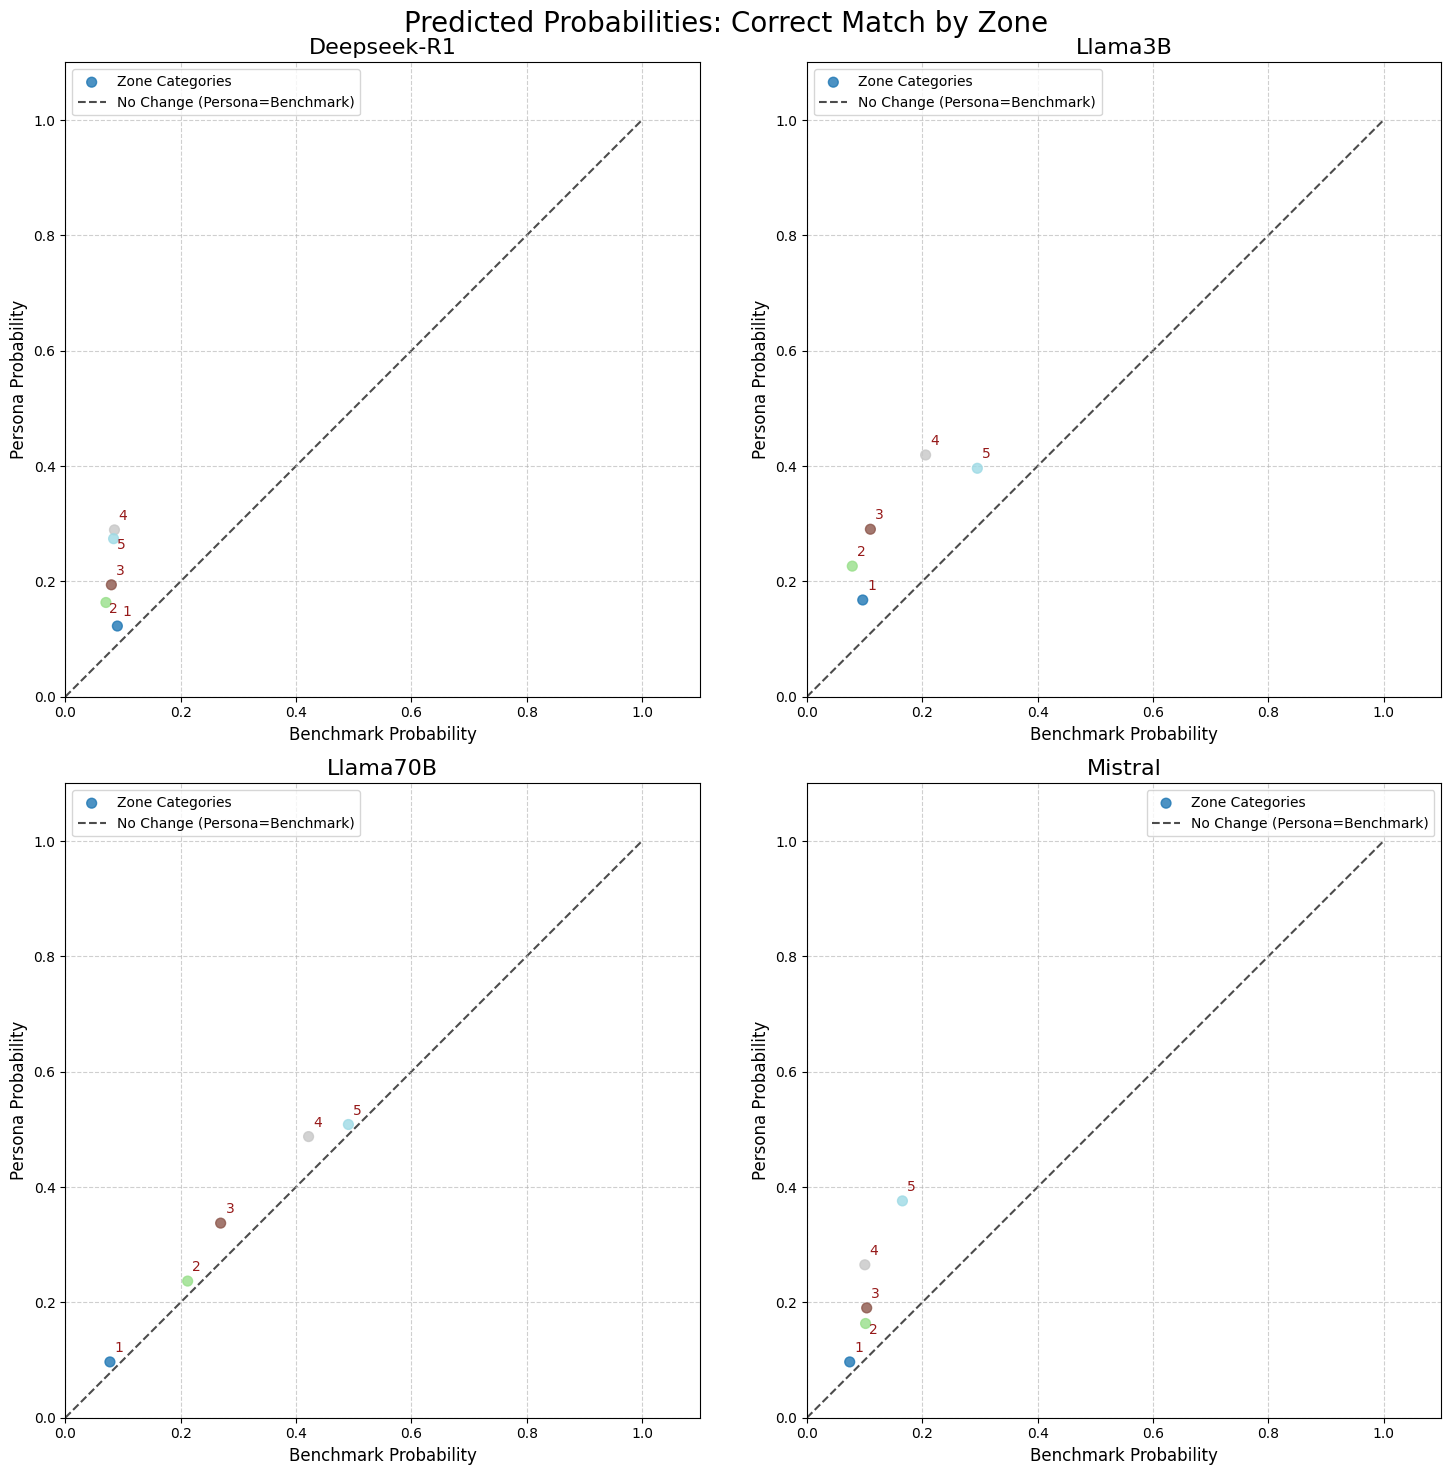

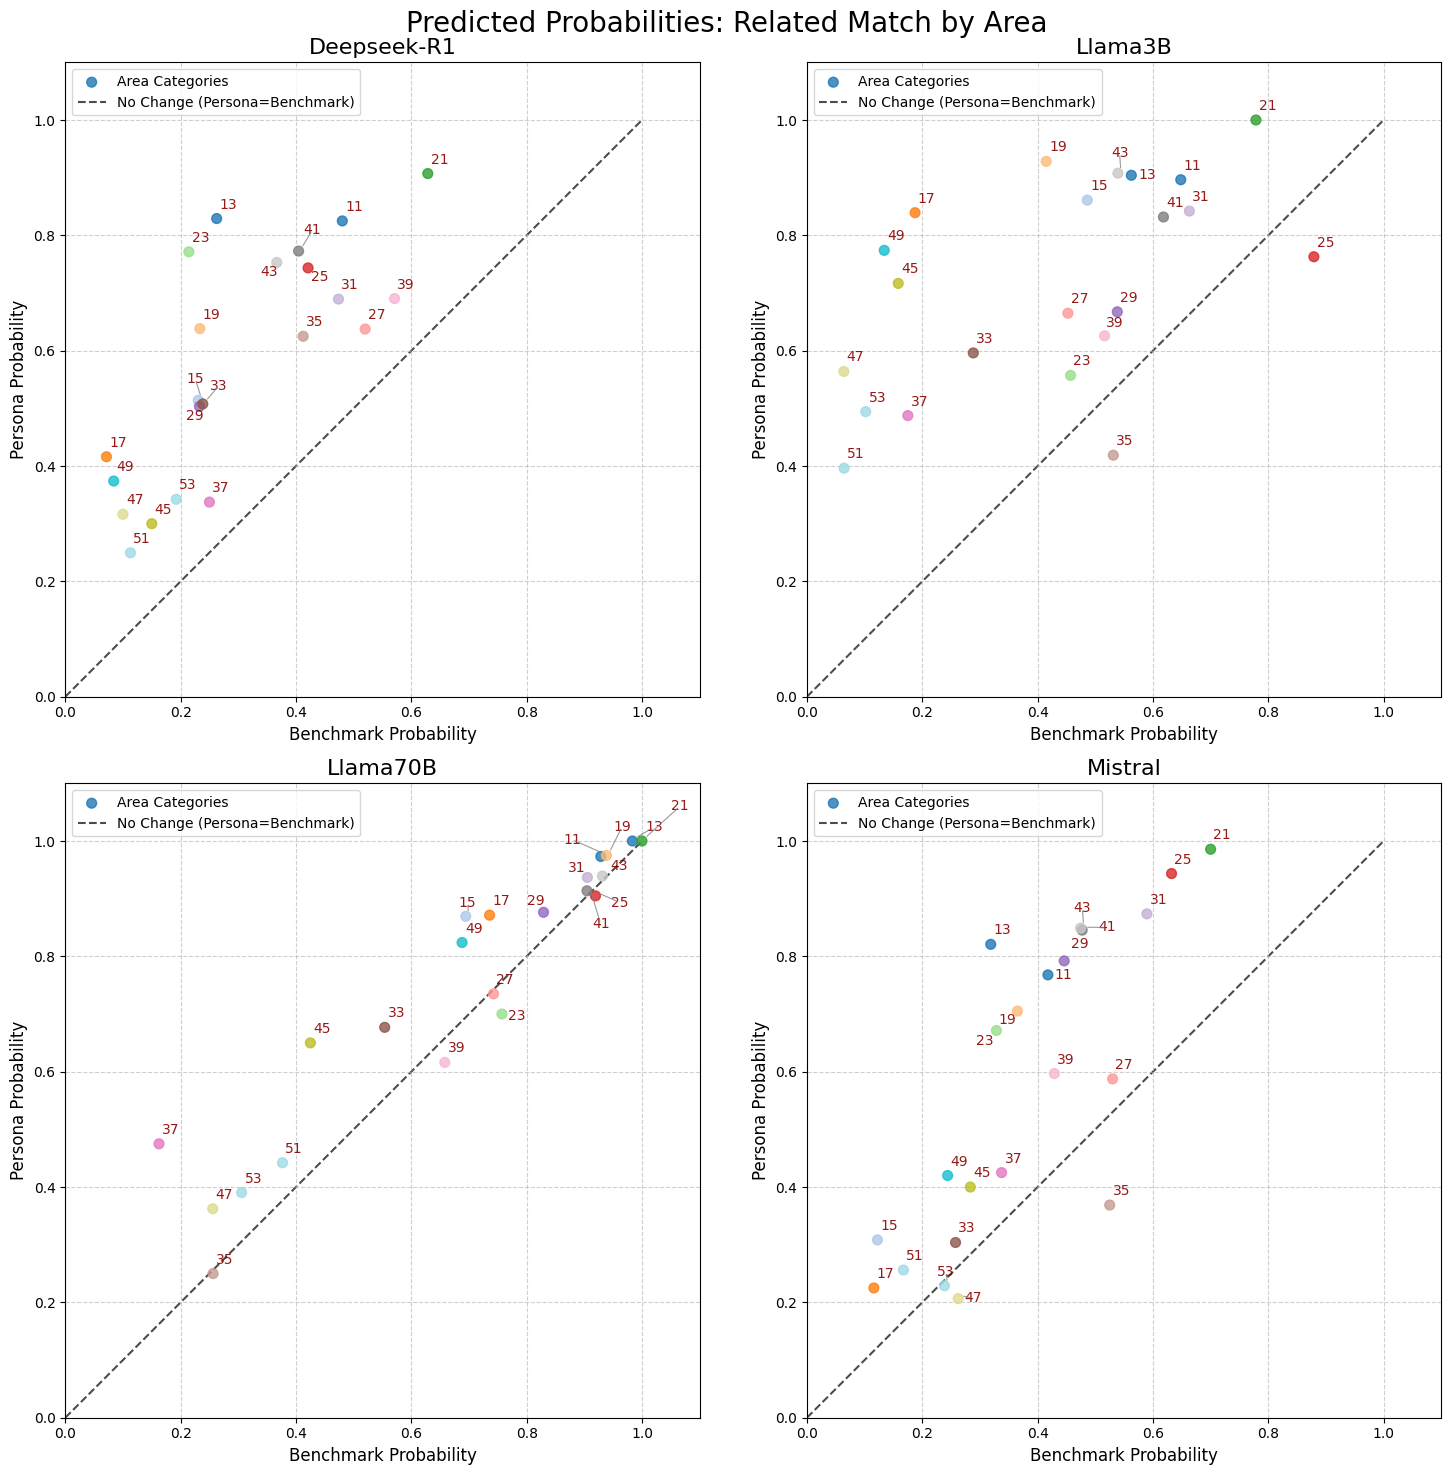

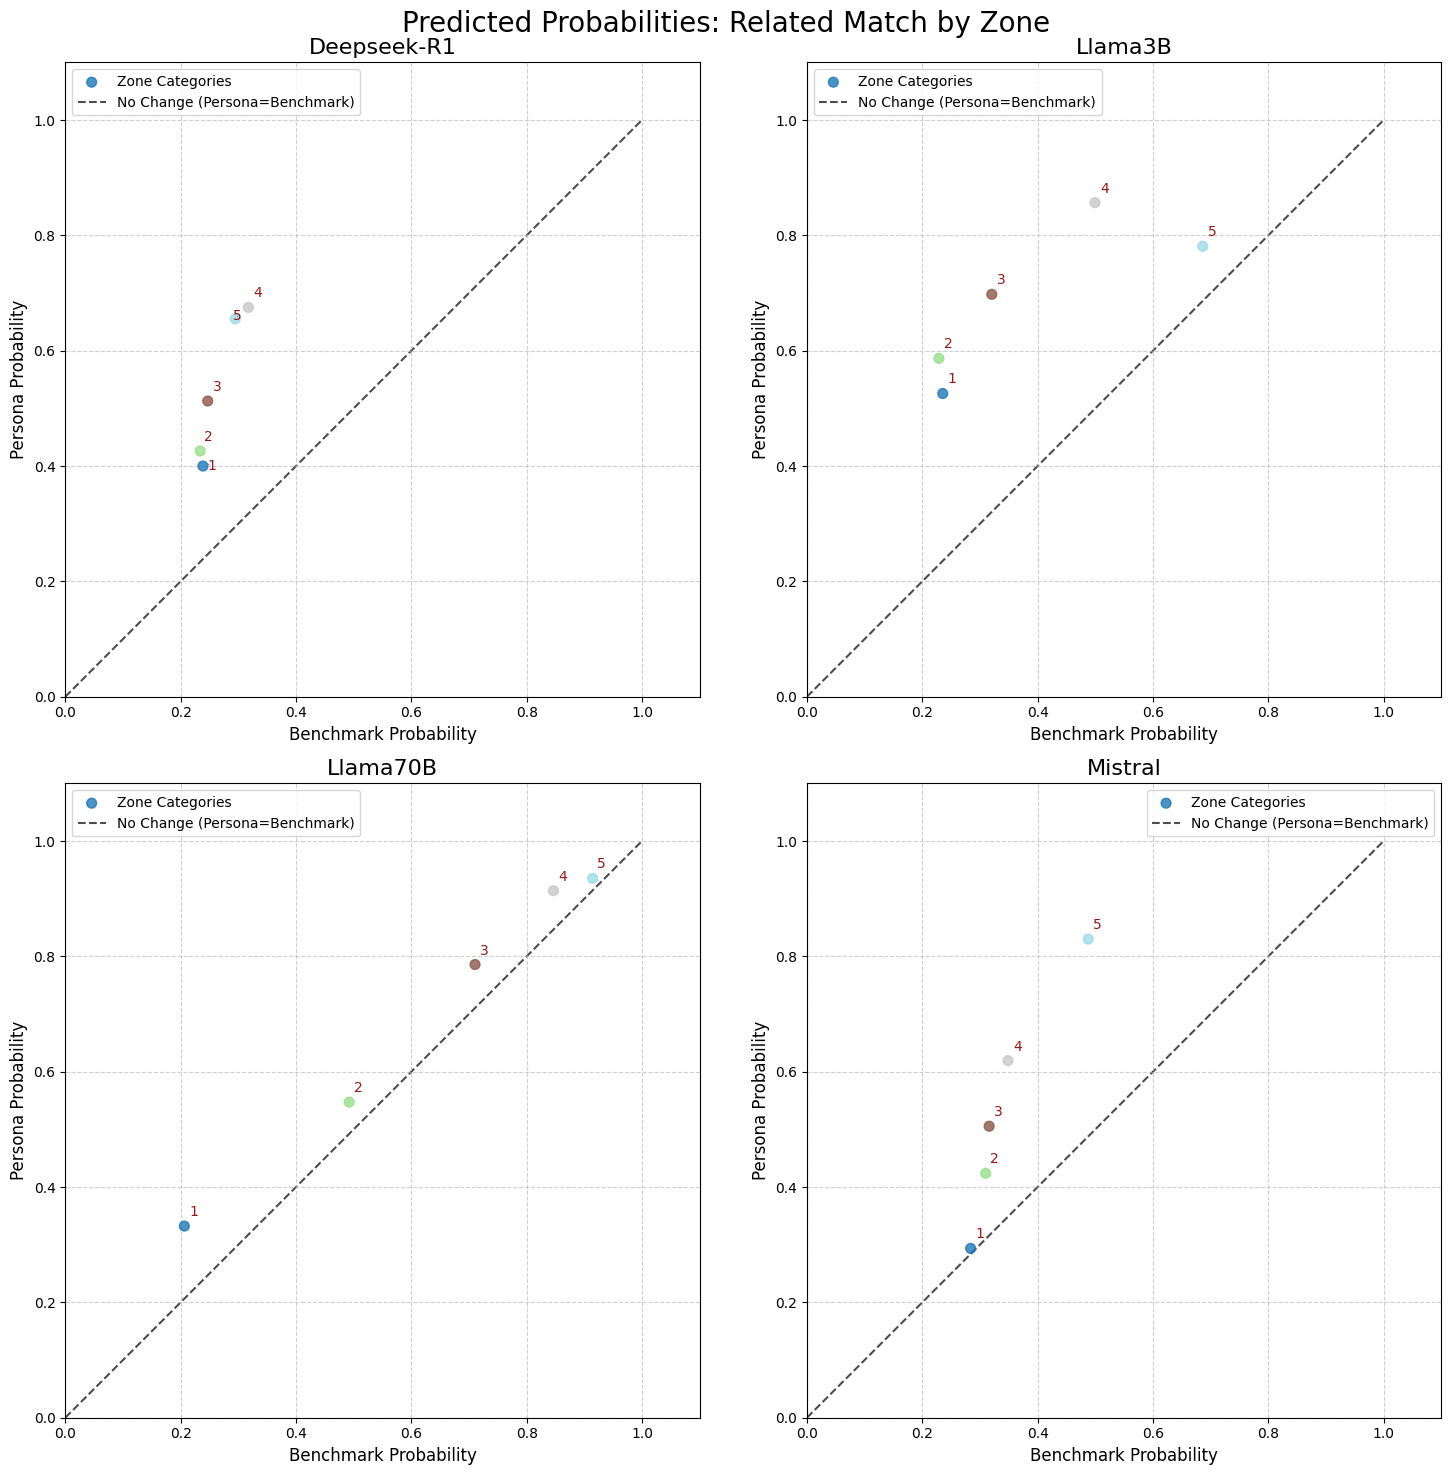

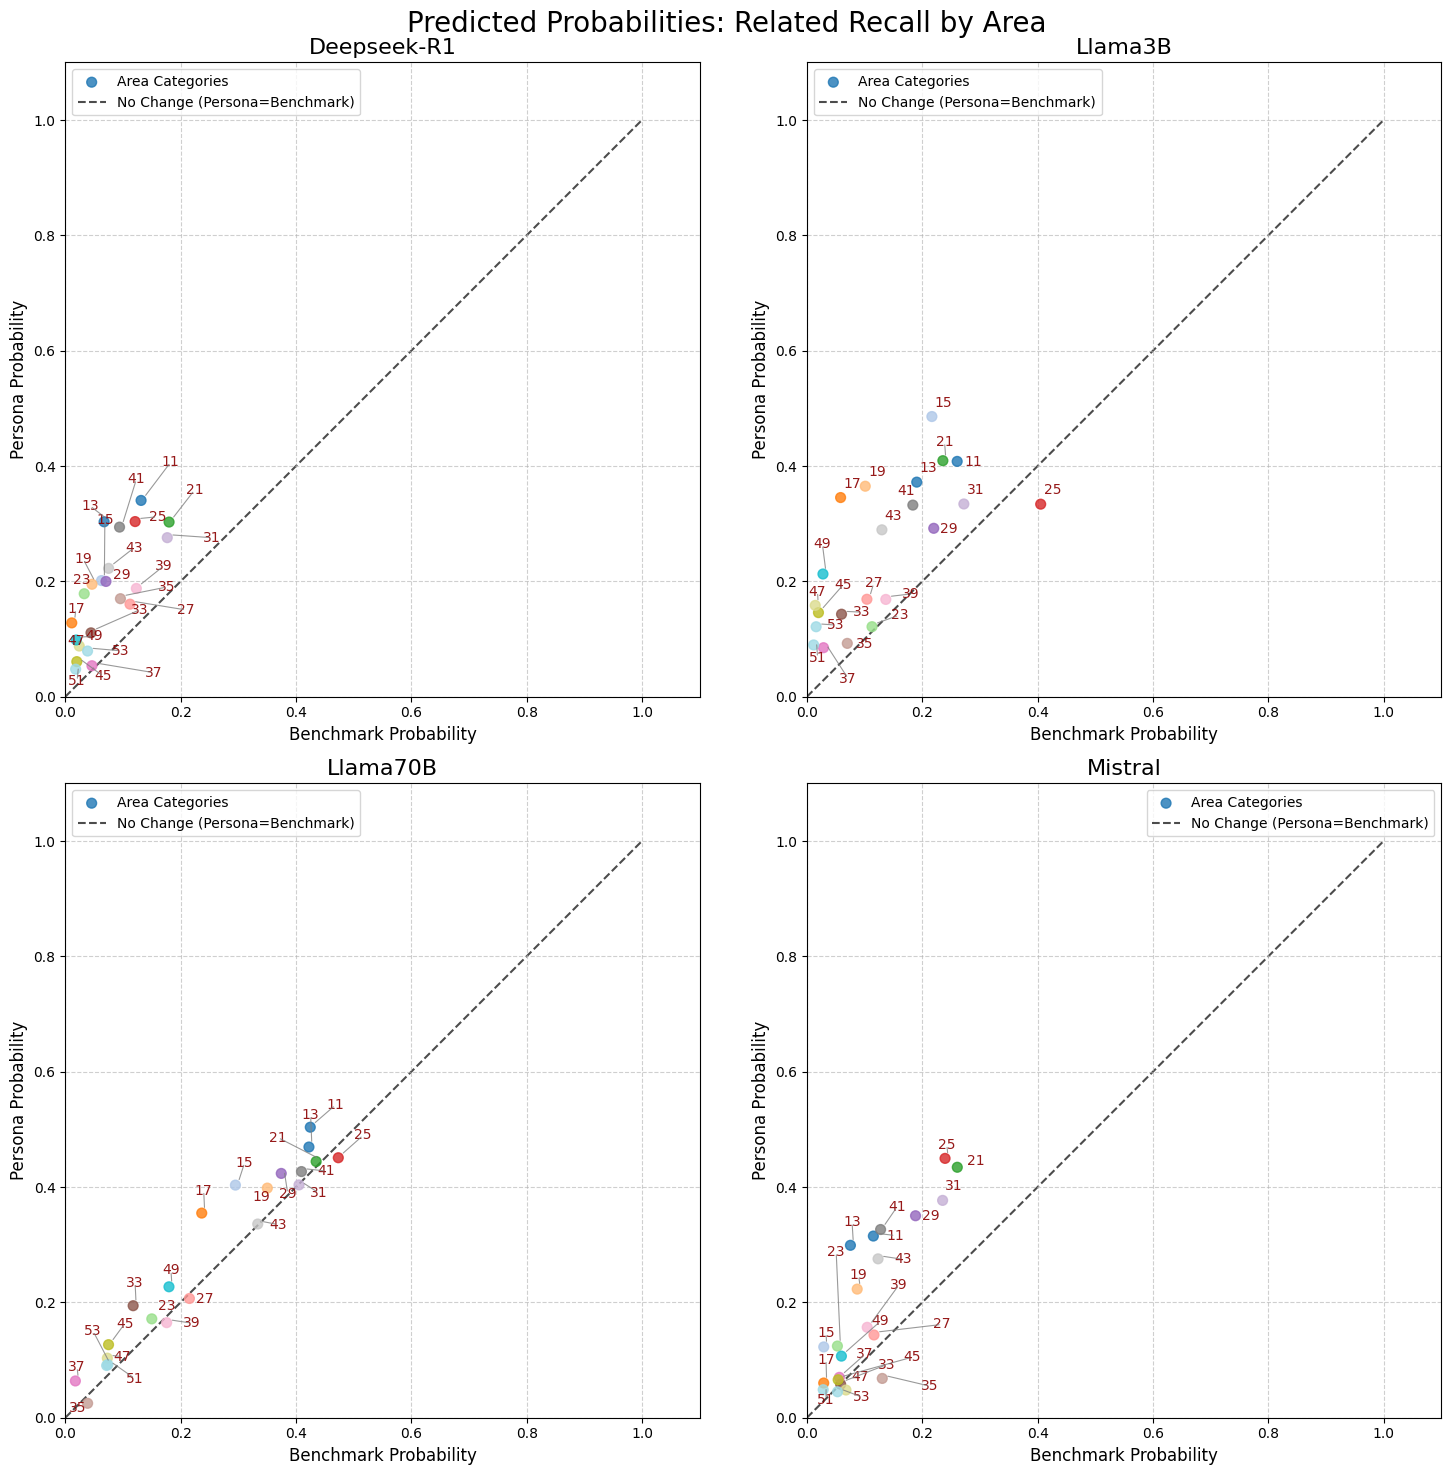

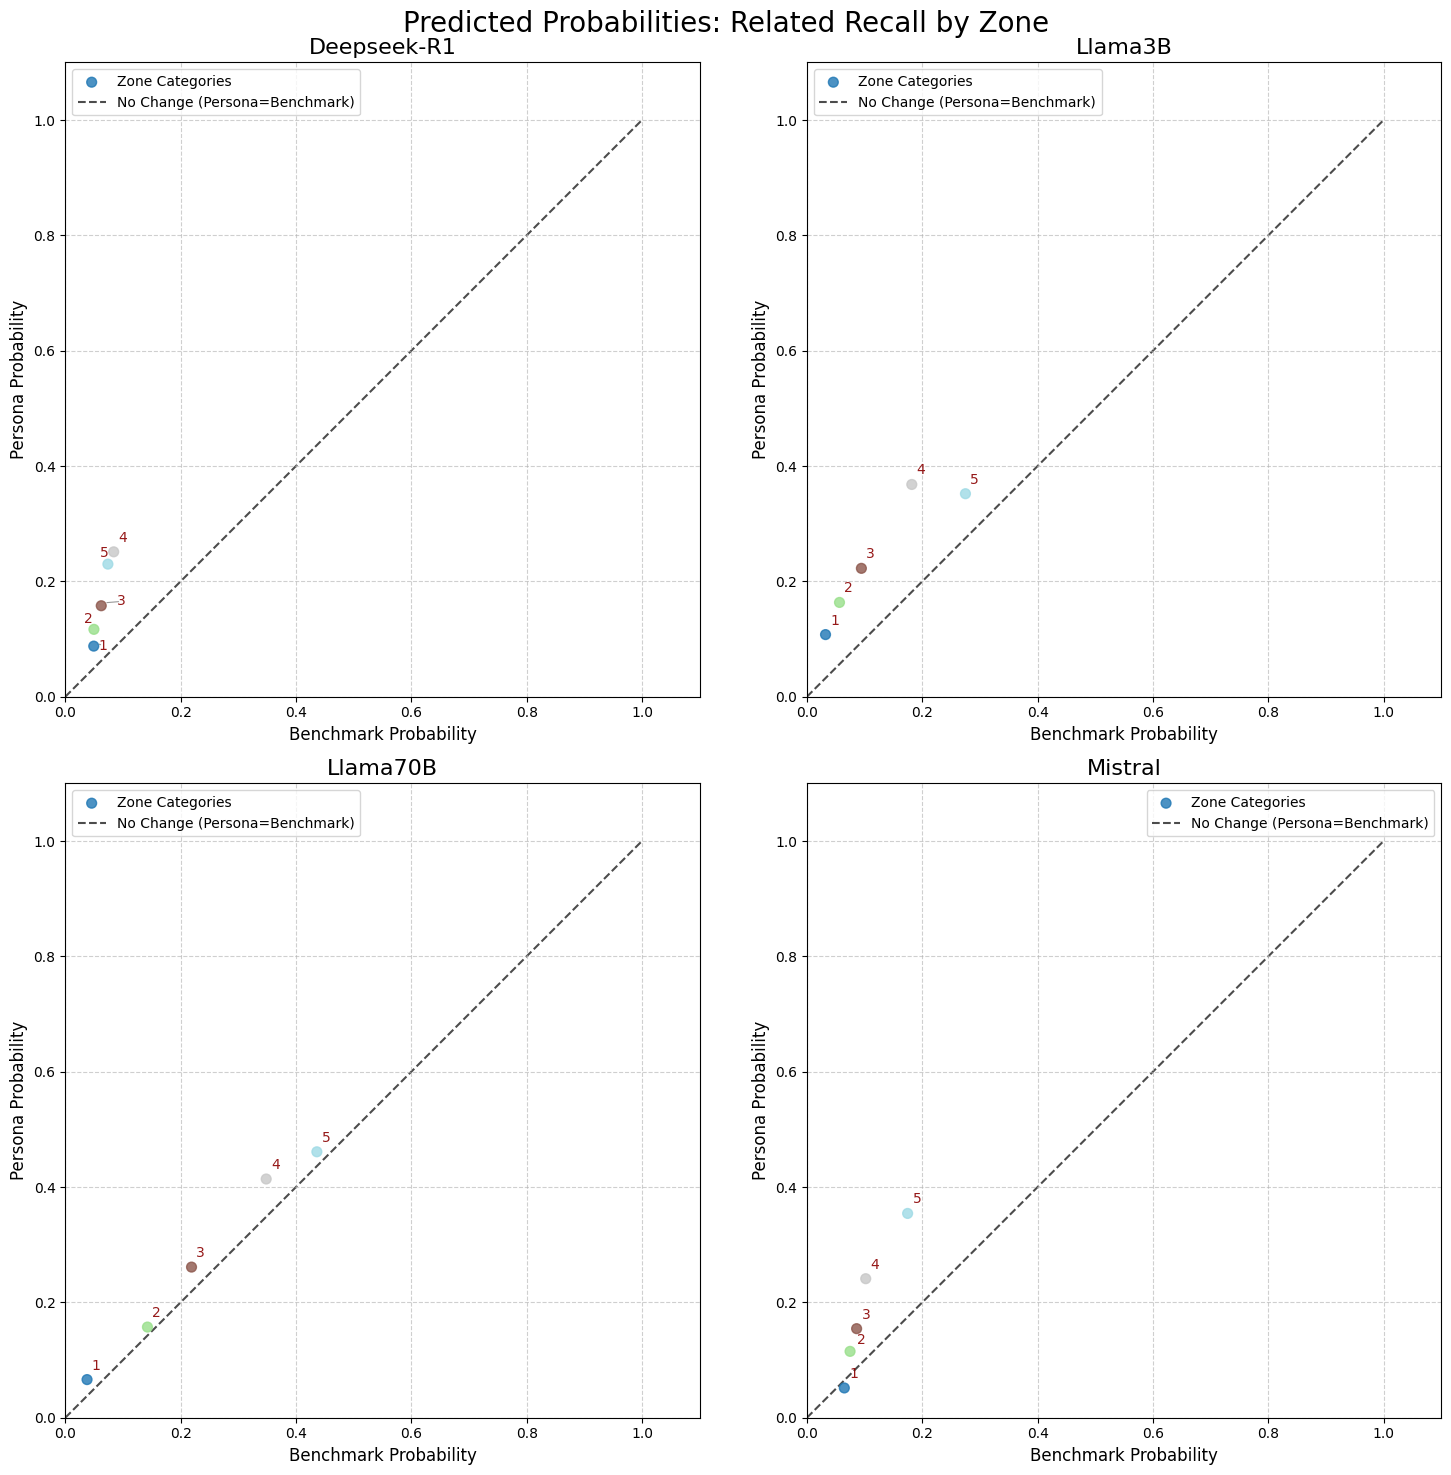

In [27]:
# --- Plotting Loop with Even More Aggressive adjust_text ---
for outcome in all_outcomes_to_plot:
    for interaction_type, pivoted_df in [('area', pivot_area_df), ('zone', pivot_zone_df)]:
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 15)) # Even larger figsize for more breathing room
        fig.suptitle(
            f'Predicted Probabilities: {outcome.replace("_", " ").title()} by {interaction_type.capitalize()}',
            fontsize=20 # Larger title font
        )
        axes = axes.flatten()

        for i, llm_name in enumerate(all_llms):
            ax = axes[i]
            interaction_col = 'area' if interaction_type == 'area' else 'zone'
            plot_df = pivoted_df[(pivoted_df['llm'] == llm_name) & (pivoted_df['outcome'] == outcome)]

            if not plot_df.empty:
                ax.set_xlim(0, 1.1)
                ax.set_ylim(0, 1.1)
                ax.set_aspect('equal', adjustable='box') 
                
                scatter_plot_artist = ax.scatter(
                    plot_df['benchmark_prob'], plot_df['persona_prob'],
                    label=f'{interaction_type.capitalize()} Categories', 
                    s=50, zorder=2, # Even larger point size for visual distinction
                    c=plot_df[interaction_col].astype('category').cat.codes, 
                    cmap='tab20', alpha=0.8 # Slightly higher alpha for points
                )

                texts = []
                for idx, row in plot_df.iterrows():
                    texts.append(
                        ax.text(
                            row['benchmark_prob'] + 0.005, row['persona_prob']+0.005, str(row[interaction_col]),
                            fontsize=10, ha='center', va='center', color='darkred', alpha=0.9 # Changed text color to red for higher contrast
                        )
                    )


                # --- NEW: Even More Aggressive adjust_text Parameters ---
                adjust_text(
                    texts,
                    x=plot_df['benchmark_prob'].values, 
                    y=plot_df['persona_prob'].values,   
                    ax=ax,
                    add_objects=[scatter_plot_artist], 
                    # SIGNIFICANTLY increased forces for max repulsion
                    force_points=(20.0, 20.0), # Push labels away from points very strongly
                    force_text=(20.0, 20.0),   # Push labels away from other labels very strongly
                    # Larger expansion factors
                    expand_points=(20.0, 20.0), # Initial buffer around points
                    expand_text=(20.0, 20.0),   # Initial buffer around other labels
                    lim=(0, 1, 0, 1), # Keep labels strictly within plot limits
                    max_iter=2000, # Increased max iterations for complex adjustments
                    # If still not moving enough, uncomment and try these
                    add_arrow_as_points=False, # Don't consider arrows as points
                    save_steps=True, # For advanced debugging if you want to visualize iterations
                    arrowprops=dict(arrowstyle='-', color='gray', lw=0.8, alpha=0.8) # Slightly thicker arrow
                )
                

                ax.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='No Change (Persona=Benchmark)', zorder=1) 
                
                ax.legend(fontsize=10, loc='upper left') 
                ax.set_title(f'{llm_name.title()}', fontsize=16) # Larger subplot title
                ax.set_xlabel('Benchmark Probability', fontsize=12) # Clear individual x-labels for common supxlabel
                ax.set_ylabel('Persona Probability', fontsize=12)
                ax.grid(True, linestyle='--', alpha=0.6)
            else:
                ax.set_title(f'{llm_name.title()} (No Data)', fontsize=16)
                ax.set_xlabel('Benchmark Probability', fontsize=12) # Clear individual x-labels for common supxlabel
                ax.set_ylabel('Persona Probability', fontsize=12) # Clear individual y-labels for common supylabel
                ax.text(0.5, 0.5, 'No data to plot', horizontalalignment='center', 
                        verticalalignment='center', transform=ax.transAxes, fontsize=14, color='gray')
        
        plt.legend()
        plt.tight_layout()
        plt.show()

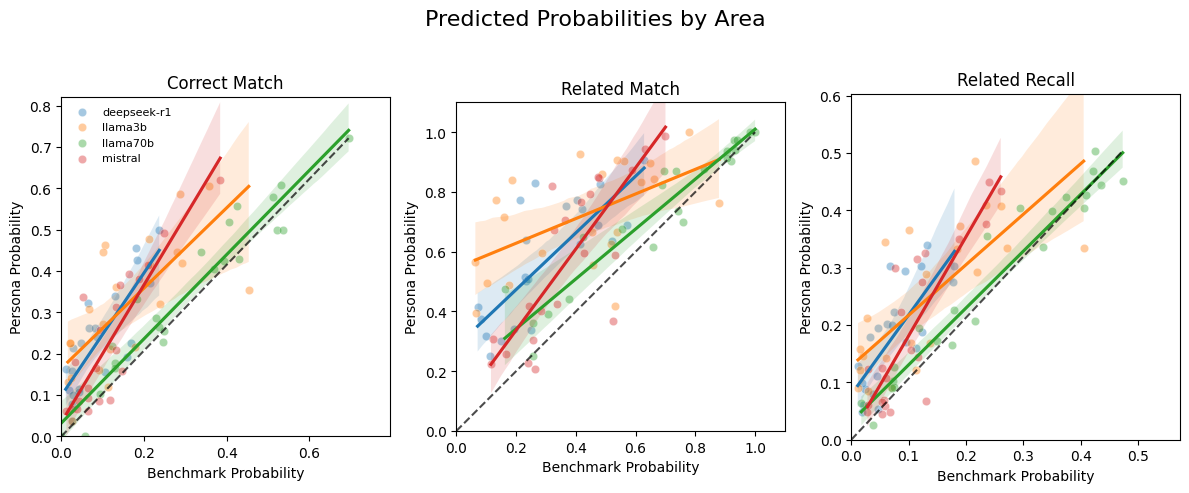

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=False, sharey=False)
plt.suptitle('Predicted Probabilities by Area', fontsize=16)
for i, outcome in enumerate(all_outcomes_to_plot):
    ax = axes[i]
    df_plot = pivot_area_df[pivot_area_df['outcome'] == outcome]
    for llm in df_plot['llm'].unique():
        sub_df = df_plot[df_plot['llm'] == llm]
        sns.scatterplot(
            data=sub_df,
            x="benchmark_prob",
            y="persona_prob",
            label=llm,
            ax=ax,
            alpha=0.4
        )
        # Fit regression line for each llm
        sns.regplot(
            data=sub_df,
            x="benchmark_prob",
            y="persona_prob",
            scatter=False,
            ax=ax,
            label=None,
            robust=True,
            line_kws={'alpha': 1}
        )
    max_x = df_plot['benchmark_prob'].max()
    max_y = df_plot['persona_prob'].max()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, max_x + 0.1)
    ax.set_ylim(0, max_y + 0.1)
    ax.plot([0, max_x], [0, max_y], 'k--', alpha=0.7)
    ax.set_xlabel("Benchmark Probability")
    ax.set_ylabel("Persona Probability")
    ax.set_title(f"{outcome.replace('_', ' ').title()}")
    if i == 0:
        ax.legend(title="", frameon=False, fontsize=8)
    else:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\robust\robust_linear_model.py:167: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\robust\robust_linear_model.py:167: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\robust\robust_linear_model.py:167: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\robust\robust_linear_model.py:167: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\robust\robust_l

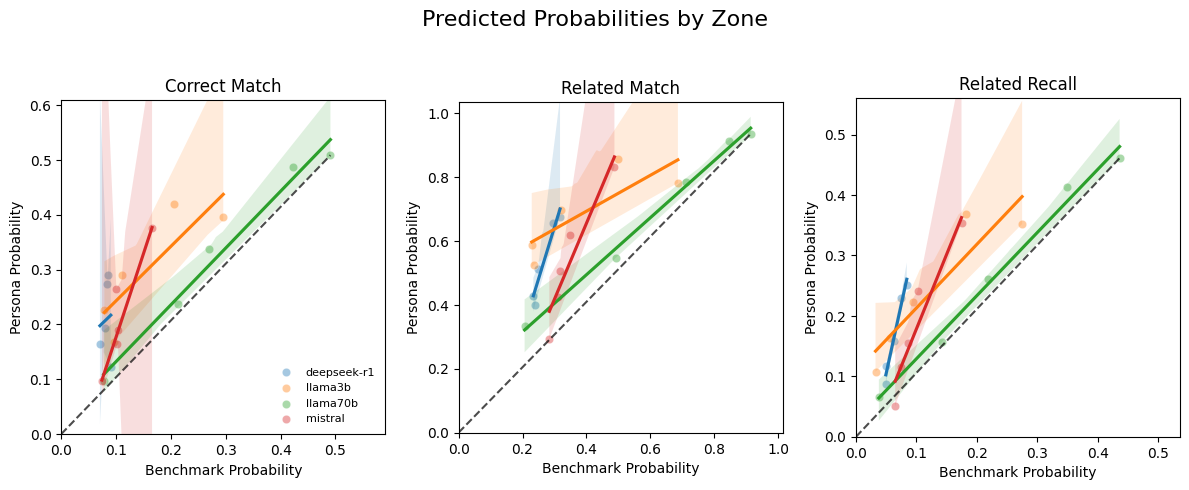

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=False, sharey=False)
plt.suptitle('Predicted Probabilities by Zone', fontsize=16)
for i, outcome in enumerate(all_outcomes_to_plot):
    ax = axes[i]
    df_plot = pivot_zone_df[pivot_zone_df['outcome'] == outcome]
    for llm in df_plot['llm'].unique():
        sub_df = df_plot[df_plot['llm'] == llm]
        sns.scatterplot(
            data=sub_df,
            x="benchmark_prob",
            y="persona_prob",
            label=llm,
            ax=ax,
            alpha=0.4
        )
        # Fit regression line for each llm
        sns.regplot(
            data=sub_df,
            x="benchmark_prob",
            y="persona_prob",
            scatter=False,
            ax=ax,
            label=None,
            robust=True,
            line_kws={'alpha': 1}
        )
    max_x = df_plot['benchmark_prob'].max()
    max_y = df_plot['persona_prob'].max()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, max_x + 0.1)
    ax.set_ylim(0, max_y + 0.1)
    ax.plot([0, max_x], [0, max_y], 'k--', alpha=0.7)
    ax.set_xlabel("Benchmark Probability")
    ax.set_ylabel("Persona Probability")
    ax.set_title(f"{outcome.replace('_', ' ').title()}")
    if i == 0:
        ax.legend(title="", frameon=False, fontsize=8)
    else:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()


In [30]:
for model_info in all_gee_results:
    llm_name = model_info['llm']
    outcome = model_info['outcome']
    interaction = model_info['interaction']
    results = model_info['results'] 

    model_title = f"GEE Model Results for {outcome.replace('_', ' ').title()} (LLM: {llm_name}, Interaction: Prompt x {interaction.capitalize()})"
    label = f"tab:gee_{llm_name.replace('-', '_')}_{outcome}_{interaction}"
    
    # Format model output for display (returns a pandas DataFrame)
    formatted_df = format_gee_results_for_latex(results, model_name=model_title, interaction_type_str=interaction)

    # Convert each row into a LaTeX table row string
    latex_rows = []
    for _, row in formatted_df.iterrows():
        row_str = f"{row['Parameter']} & {row['Estimate']:.3f} & {row['Std. Error']:.3f} & {row['Z-value']:.3f} & {row['P-value']} & {row['95% CI Lower']:.3f} & {row['95% CI Upper']:.3f} \\\\"
        latex_rows.append(row_str)

    # Join all rows
    latex_rows_str = "\n".join(latex_rows)

    # Get number of groups
    n_groups = len(getattr(results.model, 'groups', []))

    try:
        skew = results.summary().tables[1].data[-2][1]
        kurt = results.summary().tables[1].data[-2][3]
        centered_skew = results.summary().tables[1].data[-1][1]
        centered_kurt = results.summary().tables[1].data[-1][3]
    except Exception:
        skew = centered_skew = kurt = centered_kurt = "N/A"

    # Final LaTeX table string
    latex_table = f"""
\\begin{{table}}[htbp]
    \\centering
    \\resizebox{{0.8\\textwidth}}{{!}}{{%
    \\begin{{threeparttable}}
    \\caption{{{model_title}}}
    \\label{{{label}}}
    \\begin{{tabular}}{{lrrrlll}}
        \\toprule
        Parameter & Est. & Std. Err. & Z-val. & P-val. & [0.025 & 0.975] \\\\
        \\midrule
        
{latex_rows_str}
        
        \\bottomrule
    \\end{{tabular}}

    \\begin{{tablenotes}}[flushleft]
    \\footnotesize
    Note: $* p < 0.05$; $** p < 0.01$; $*** p < 0.001$. Estimates are on the log-odds scale. \\\\
    N = {results.nobs:.0f} observations, {n_groups} groups. \\\\
    Skew: {skew}, Kurtosis: {kurt}; Centered Skew: {centered_skew}, Centered Kurtosis: {centered_kurt}
    \\end{{tablenotes}}
    
    \\end{{threeparttable}}
    }}
\\end{{table}}
""".strip()

    # Print for preview

    print(latex_table)





\begin{table}[htbp]
    \centering
    \resizebox{0.8\textwidth}{!}{%
    \begin{threeparttable}
    \caption{GEE Model Results for Correct Match (LLM: deepseek-r1, Interaction: Prompt x Area)}
    \label{tab:gee_deepseek_r1_correct_match_area}
    \begin{tabular}{lrrrlll}
        \toprule
        Parameter & Est. & Std. Err. & Z-val. & P-val. & [0.025 & 0.975] \\
        \midrule
        
Intercept & -1.502 & 0.201 & -7.485 & $<$0.001*** & -1.895 & -1.109 \\
Persona & 1.207 & 0.197 & 6.122 & $<$0.001*** & 0.821 & 1.593 \\
Area 13 & -1.171 & 0.346 & -3.382 & $<$0.001*** & -1.850 & -0.492 \\
Area 15 & -1.137 & 0.297 & -3.831 & $<$0.001*** & -1.719 & -0.555 \\
Area 17 & -3.024 & 0.439 & -6.895 & $<$0.001*** & -3.883 & -2.164 \\
Area 19 & -1.515 & 0.347 & -4.370 & $<$0.001*** & -2.194 & -0.836 \\
Area 21 & 0.203 & 0.527 & 0.385 & 0.700 & -0.830 & 1.235 \\
Area 23 & -2.024 & 0.647 & -3.129 & 0.002** & -3.293 & -0.756 \\
Area 25 & -0.408 & 0.307 & -1.327 & 0.185 & -1.010 & 0.195 \\
Area 27 